# Analysis of Authorship in Arabic sources

Implementation Overview

This codebase implements an Arabic authorship verification research based on the Deep Impostors
, the system trains multiple Siamese models on
pairs of impostor authors and evaluates how test texts behave relative to these stylistic boundaries.
Authorship verification is formulated as a signal comparison and anomaly detection problem.

Pipeline summary
1. Preprocessing:
Cleans and normalizes Arabic texts. Produces clean corpora for impostor authors and test books.
2. AraBERT Fine Tuning:
Fine tunes AraBERT using masked language modeling to adapt representations to the project corpus.
3. Test Book Embedding:
Segments test books and generates CLS embeddings using the fine tuned AraBERT model. Saves embeddings per book and segment.
4. Training and Signal Generation:
Trains a Siamese CNN BiLSTM model for each impostor pair. Evaluates all test books using the trained model and saves one dimensional stylometric signals per book per pair. Training is resumable using the completed pairs log.
5. DTW Similarity Analysis :
Computes DTW distance matrices between book signals for each impostor pair. Saves per pair DTW matrices, heatmaps, and metadata under a structured Drive layout. Also saves an aggregate DTW state file and a manifest for resumable execution.
6. Isolation Forest Anomaly Detection :
Reads DTW outputs from Drive and applies Isolation Forest per impostor pair. Saves per pair anomaly labels, scores, CSV tables, scatter plots, and metadata. Produces aggregate summaries such as anomaly frequency and score matrices, plus an averaged score matrix for multi part books.
7. K Means Clustering :
Clusters Isolation Forest scores per impostor pair. Saves per pair cluster tables, plots, and metadata. Saves an aggregate manifest and state file listing successful clustering runs.

Running Guide :
1. Create a folder named (capstone) in your google drive.
2. Download all files from https://github.com/mayarsaleh4/CapstoneProject/tree/d5eccaa16ca013bda2d239ced5ac7ce1a99bd3df/Phase%20B/Pipeline%20Setup
3. Add imported files to the (capstone) folder in your Google Drive
4. Set the runtime on colab to be A100 GPU ,if you have stronger GPU environment we suggest running the training section there.
5. Mount Google Drive.
6. Run the all sections sequentially in the notebook.
* Each section is implemented as an independent module. When a section is run, it saves all the required data to Drive, allowing the following sections to be executed independently.

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing
   Convert raw Arabic .txt files into a clean, standardized form that is stable for:
  - contextual embedding (AraBERT)
  - Siamese training on impostor pairs
  - signal generation and DTW comparison

 Why we do this:
   Arabic books often contain digitization artifacts (OCR spacing, mixed symbols, diacritics,
   inconsistent letter variants). If left uncleaned, the model may learn noise rather than style.
   This step reduces noise and makes stylistic signals comparable across books.

 Inputs
   - Folder of raw .txt files (impostors grouped in subfolders, test books in a flat folder).
   - Each file should be UTF-8 Arabic text (Classical Arabic supported).

 Outputs
   - A mirrored folder of cleaned .txt files, with suffix "_cleaned".
   - Basic processing stats: total / ok / failed.


In [ ]:
!pip install camel-tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 115.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5a80e33920e80617c32d1323d17dbb0cf4e44d5a6986bdf7e1a57d5d0155fe8e
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf4605935

In [ ]:
import os
import re
from pathlib import Path

from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.normalize import (
    normalize_alef_ar,
    normalize_alef_maksura_ar,
    normalize_teh_marbuta_ar,
)
from camel_tools.utils.dediac import dediac_ar

# Stopwords and short-token policy
# CUSTOM_STOPWORDS:
#   A small, conservative list of common Arabic function words.
#   Removing them reduces dominance of high-frequency grammar words and improves stylistic focus.
CUSTOM_STOPWORDS = {
    'في', 'من', 'على', 'إلى', 'عن', 'هو', 'هي', 'هذا', 'هذه', 'ذلك', 'تلك',
    'ما', 'ماذا', 'لماذا', 'متى', 'أين', 'كيف', 'هل', 'لا', 'نعم', 'أنا',
    'نحن', 'أنت', 'أنتم', 'إن', 'كان', 'يا'
}

KEEP_ONE_CHAR = {'لا', 'ما', 'إن'}  # allowed 1-char tokens or special short tokens

# Cleaner
_AR_LETTER = r'[\u0621-\u064A]'
_RE_SPACED_LETTERS = re.compile(rf'(?:\b{_AR_LETTER}\s){{2,}}{_AR_LETTER}\b') # Handles OCR artifacts like: "ا ل ج ا ح ظ" (letters separated by spaces).
_RE_AR_PUNCT = re.compile(r'[،؛؟ـ“”‘’…«»‹›⸮]') # Removes Arabic punctuation marks and elongation.
_RE_NON_AR = re.compile(r'[^\u0621-\u064A\s]') # Removes Latin letters, digits, symbols, and markup that appear in digitized books.
_RE_WS = re.compile(r'\s+')


def preprocess_arabic_text(
    text: str,
    stopwords: set[str] = CUSTOM_STOPWORDS,
    keep_one_char: set[str] = KEEP_ONE_CHAR,
) -> str:
    """
    Clean Arabic text:
    - remove spaced-letter sequences
    - remove Arabic punctuation + tatweel
    - remove non-Arabic letters/digits/symbols
    - tokenize
    - remove stopwords + junk short tokens
    - normalize alef/alef-maksura/teh-marbuta + dediacritize
    Input
      - text: raw file content (string)

    Output
      - cleaned string (space-separated tokens)
      - returns "" if the text becomes empty after cleaning
    """
    if not isinstance(text, str):
        raise TypeError("preprocess_arabic_text expects a string")

    text = _RE_SPACED_LETTERS.sub(" ", text)
    text = _RE_AR_PUNCT.sub("", text)
    text = _RE_NON_AR.sub(" ", text)
    text = _RE_WS.sub(" ", text).strip()

    if not text:
        return ""

    tokens = simple_word_tokenize(text)

    cleaned_tokens: list[str] = []
    for tok in tokens:
        if tok in stopwords:
            continue
        if len(tok) <= 1 and tok not in keep_one_char:
            continue

        tok = normalize_alef_ar(tok)
        tok = normalize_alef_maksura_ar(tok)
        tok = normalize_teh_marbuta_ar(tok)
        tok = dediac_ar(tok)

        tok = tok.strip()
        if tok:
            cleaned_tokens.append(tok)

    return " ".join(cleaned_tokens)



# Generic folder processor
def preprocess_txt_tree(
    input_root: str | Path,
    output_root: str | Path,
    *,
    recursive: bool = True,
    preserve_structure: bool = True,
    output_suffix: str = "_cleaned",
    encoding: str = "utf-8",
) -> dict:
    """
     Batch preprocess all .txt files under input_root and write cleaned versions to output_root.

    Input
      - input_root: folder containing raw .txt files
      - output_root: folder to store cleaned .txt files

    Key options
      - recursive:
          True  -> process **/*.txt (includes subfolders, used for impostors by author)
          False -> process *.txt only (flat folder, used for test set)
      - preserve_structure:
          True  -> replicate subfolder structure inside output_root
          False -> write all outputs directly in output_root
      - output_suffix:
          Suffix added to output filenames (e.g., book_cleaned.txt)

    Output
      - Writes cleaned .txt files to disk
      - Returns stats dict: {"total": X, "ok": Y, "failed": Z}

    Why this function exists
      We keep preprocessing consistent for both test and impostors, while allowing different folder layouts.
    """
    in_root = Path(input_root)
    out_root = Path(output_root)
    out_root.mkdir(parents=True, exist_ok=True)

    if not in_root.exists():
        raise FileNotFoundError(f"Input path not found: {in_root}")

    pattern = "**/*.txt" if recursive else "*.txt"
    txt_files = sorted(in_root.glob(pattern))

    stats = {"total": 0, "ok": 0, "failed": 0}

    for in_path in txt_files:
        if not in_path.is_file():
            continue

        stats["total"] += 1

        # Decide output path
        if preserve_structure:
            rel_parent = in_path.parent.relative_to(in_root)
            out_dir = out_root / rel_parent
        else:
            out_dir = out_root

        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"{in_path.stem}{output_suffix}{in_path.suffix}"

        try:
            raw = in_path.read_text(encoding=encoding, errors="strict")
            cleaned = preprocess_arabic_text(raw)
            out_path.write_text(cleaned, encoding=encoding)

            print(f"Cleaned: {in_path.relative_to(in_root)} -> {out_path.relative_to(out_root)}")
            stats["ok"] += 1
        except Exception as e:
            print(f"Error: {in_path} . {e}")
            stats["failed"] += 1

    print(
        f"\nDone. total={stats['total']} ok={stats['ok']} failed={stats['failed']}"
    )
    return stats



# Run: Impostors (grouped by author folders)
impostors_input_dir = "/content/drive/MyDrive/capstone/impostors_data"
impostors_output_dir = "/content/drive/MyDrive/capstone/impostors_preprocessed"

preprocess_txt_tree(
    impostors_input_dir,
    impostors_output_dir,
    recursive=True,
    preserve_structure=True,   # keeps author subfolders
    output_suffix="_cleaned",
)


# Run: Test (flat folder)
test_input_dir = "/content/drive/MyDrive/capstone/test_data"
test_output_dir = "/content/drive/MyDrive/capstone/test_preprocessed"

preprocess_txt_tree(
    test_input_dir,
    test_output_dir,
    recursive=False,           # only top-level .txt files
    preserve_structure=False,  # all outputs directly in test_output_dir
    output_suffix="_cleaned",
)

Cleaned: Author 1/AbuHayyanTawhidi_Basair.txt -> Author 1/AbuHayyanTawhidi_Basair_cleaned.txt
Cleaned: Author 1/AbuHayyanTawhidi_Imtac.txt -> Author 1/AbuHayyanTawhidi_Imtac_cleaned.txt
Cleaned: Author 1/AbuHayyanTawhidi_Muqabasat.txt -> Author 1/AbuHayyanTawhidi_Muqabasat_cleaned.txt
Cleaned: Author 10/Yacqubi_Buldan.txt -> Author 10/Yacqubi_Buldan_cleaned.txt
Cleaned: Author 10/Yacqubi_MushakalatNas.txt -> Author 10/Yacqubi_MushakalatNas_cleaned.txt
Cleaned: Author 10/Yacqubi_Tarikh.txt -> Author 10/Yacqubi_Tarikh_cleaned.txt
Cleaned: Author 2/AbuMansurThacalibi_AhsanMaSamictu.txt -> Author 2/AbuMansurThacalibi_AhsanMaSamictu_cleaned.txt
Cleaned: Author 2/AbuMansurThacalibi_YatimatDahr.txt -> Author 2/AbuMansurThacalibi_YatimatDahr_cleaned.txt
Cleaned: Author 3/Baladhuri_AnsabAshraf.txt -> Author 3/Baladhuri_AnsabAshraf_cleaned.txt
Cleaned: Author 3/Baladhuri_FutuhBuldan.txt -> Author 3/Baladhuri_FutuhBuldan_cleaned.txt
Cleaned: Author 4/IbnCabdRabbih_CiqdFarid.txt -> Author 4/IbnCab

{'total': 90, 'ok': 90, 'failed': 0}

# Fine-tuning Arabert

This section adapts AraBERT v2 to the writing style and vocabulary distribution of the project corpus.
The corpus is built from the preprocessed test texts and the preprocessed impostor texts. The training
objective is Masked Language Modeling (MLM), where the model learns to recover randomly masked tokens
from their surrounding context.

Why this step is included:

Fine tuning reduces domain mismatch between the original AraBERT pretraining data and the project
collection of classical Arabic sources. The resulting embeddings are more sensitive to the project’s
stylistic and lexical patterns. This improves the stability of the downstream Siamese training and
the quality of the generated stylometric signals.

Inputs
-  Preprocessed test texts folder
-  Preprocessed impostor texts folder
-  Base model identifier for AraBERT v2

Outputs
-  A fine tuned MLM model saved to MLM_OUTPUT_DIR
-  A tokenizer saved to the same directory
-  Console logs reporting dataset size and basic training progress

In [ ]:
# Install dependencies
# transformers provides AraBERT model classes and the Trainer interface.
# datasets provides a lightweight dataset object for token blocks.
# accelerate is used under the hood by Trainer for efficient training.
!pip -q install -U "transformers>=4.45.0" "datasets>=2.20.0" "accelerate" "evaluate"

import os
import math
import random
from pathlib import Path

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    pipeline,
)

In [ ]:
#  MLM Fine-Tuning Configuration
# Model
MLM_BASE_MODEL_NAME = "aubmindlab/bert-base-arabertv2"

# Data folders on Drive.
MLM_TEST_TEXT_DIR = Path("/content/drive/MyDrive/capstone/test_preprocessed")
MLM_IMPOSTOR_TEXT_DIR = Path("/content/drive/MyDrive/capstone/impostors_preprocessed")

# Output
MLM_OUTPUT_DIR = Path("/content/drive/MyDrive/capstone/arabert_finetuned")

# Segmentation and tokenization
MLM_MAX_SEQ_LEN = 128
MLM_SEGMENT_STRIDE = 128

# MLM objective
MLM_MASK_PROBABILITY = 0.15

# Split
MLM_VALIDATION_RATIO = 0.10
MLM_RANDOM_SEED = 42

# Training hyperparameters
MLM_NUM_EPOCHS = 2
MLM_TRAIN_BATCH_SIZE = 8
MLM_EVAL_BATCH_SIZE = 8
MLM_LEARNING_RATE = 2e-5
MLM_WEIGHT_DECAY = 0.01

# Logging and saving
MLM_LOGGING_STEPS = 200
MLM_SAVE_LIMIT = 2

# Precision
MLM_USE_FP16 = True  # set False if you do not have a GPU

print("MLM_BASE_MODEL_NAME:", MLM_BASE_MODEL_NAME)
print("MLM_TEST_TEXT_DIR:", MLM_TEST_TEXT_DIR)
print("MLM_IMPOSTOR_TEXT_DIR:", MLM_IMPOSTOR_TEXT_DIR)
print("MLM_OUTPUT_DIR:", MLM_OUTPUT_DIR)
print("MLM_MAX_SEQ_LEN:", MLM_MAX_SEQ_LEN, "MLM_SEGMENT_STRIDE:", MLM_SEGMENT_STRIDE)

MLM_BASE_MODEL_NAME: aubmindlab/bert-base-arabertv2
MLM_TEST_TEXT_DIR: /content/drive/MyDrive/capstone/test_preprocessed
MLM_IMPOSTOR_TEXT_DIR: /content/drive/MyDrive/capstone/impostors_preprocessed
MLM_OUTPUT_DIR: /content/drive/MyDrive/capstone/arabert_finetuned
MLM_MAX_SEQ_LEN: 128 MLM_SEGMENT_STRIDE: 128


In [ ]:
# Reproducibility and device
# This sets the same random seed across Python and PyTorch.
# If CUDA is available, the seed is also applied to all GPU devices.
random.seed(MLM_RANDOM_SEED)
torch.manual_seed(MLM_RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(MLM_RANDOM_SEED)

MLM_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", MLM_DEVICE)

Device: cuda


In [ ]:
# Load text files
# This function scans a folder tree and loads all .txt files.
def mlm_read_all_txt_files(folder_path: Path):
    rows = []
    if not folder_path.exists():
        raise FileNotFoundError(f"Folder not found: {folder_path}")

    file_list = sorted([p for p in folder_path.rglob("*") if p.is_file() and p.suffix.lower() == ".txt"])
    for file_path in file_list:
        try:
            text = file_path.read_text(encoding="utf-8", errors="ignore").strip()
            if text:
                rows.append({"source_path": str(file_path), "text": text})
        except Exception as exc:
            print("Failed reading:", file_path, "error:", exc)
    return rows

mlm_test_rows = mlm_read_all_txt_files(MLM_TEST_TEXT_DIR)
mlm_impostor_rows = mlm_read_all_txt_files(MLM_IMPOSTOR_TEXT_DIR)

mlm_all_rows = mlm_test_rows + mlm_impostor_rows
if not mlm_all_rows:
    raise ValueError("No .txt files were loaded. Check your folder paths and extensions.")

print("Loaded files total:", len(mlm_all_rows))
print("Loaded test files:", len(mlm_test_rows))
print("Loaded impostor files:", len(mlm_impostor_rows))
print("Example:", mlm_all_rows[0]["source_path"], "chars:", len(mlm_all_rows[0]["text"]))

Loaded files total: 115
Loaded test files: 90
Loaded impostor files: 25
Example: /content/drive/MyDrive/capstone/test_preprocessed/AmilWaMamul_001_cleaned.txt chars: 103683


In [ ]:
# Tokenizer
mlm_tokenizer = AutoTokenizer.from_pretrained(MLM_BASE_MODEL_NAME, use_fast=True)
print("Tokenizer vocab size:", mlm_tokenizer.vocab_size)
print("CLS:", mlm_tokenizer.cls_token_id, "SEP:", mlm_tokenizer.sep_token_id, "PAD:", mlm_tokenizer.pad_token_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer vocab size: 64000
CLS: 33 SEP: 34 PAD: 31


In [ ]:
# Segment each document into many token blocks
def mlm_segment_text_to_blocks(
    text: str,
    tokenizer: AutoTokenizer,
    block_seq_len: int,
    stride: int,
):
    """
    Creates many fixed-length segments from a long document.
    Each segment is exactly block_seq_len tokens including [CLS] and [SEP].
    """
    if not text:
        return []

    token_ids = tokenizer.encode(text, add_special_tokens=False)
    if len(token_ids) < 8:
        return []

    usable_len = block_seq_len - 2
    blocks = []

    for start in range(0, len(token_ids), stride):
        chunk = token_ids[start:start + usable_len]
        if len(chunk) < 8:
            continue

        chunk = [tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id]

        if len(chunk) < block_seq_len:
            chunk = chunk + [tokenizer.pad_token_id] * (block_seq_len - len(chunk))
        else:
            chunk = chunk[:block_seq_len]

        blocks.append(chunk)

    return blocks

mlm_input_ids_list = []
mlm_attention_mask_list = []

for row in mlm_all_rows:
    blocks = mlm_segment_text_to_blocks(
        text=row["text"],
        tokenizer=mlm_tokenizer,
        block_seq_len=MLM_MAX_SEQ_LEN,
        stride=MLM_SEGMENT_STRIDE,
    )
    for block in blocks:
        mlm_input_ids_list.append(block)
        mlm_attention_mask_list.append([0 if tid == mlm_tokenizer.pad_token_id else 1 for tid in block])

print("Total MLM segments:", len(mlm_input_ids_list))
if len(mlm_input_ids_list) < 500:
    print("Note: segment count is small. Consider lowering MLM_SEGMENT_STRIDE to create overlapping segments.")

Token indices sequence length is longer than the specified maximum sequence length for this model (32408 > 512). Running this sequence through the model will result in indexing errors


Total MLM segments: 30356


In [ ]:
# Build HuggingFace dataset and split into train and evaluation sets
mlm_full_dataset = Dataset.from_dict({
    "input_ids": mlm_input_ids_list,
    "attention_mask": mlm_attention_mask_list,
})

mlm_split = mlm_full_dataset.train_test_split(
    test_size=MLM_VALIDATION_RATIO,
    seed=MLM_RANDOM_SEED,
)
mlm_train_dataset = mlm_split["train"]
mlm_eval_dataset = mlm_split["test"]

print("Train segments:", len(mlm_train_dataset))
print("Eval segments:", len(mlm_eval_dataset))
print("Columns:", mlm_train_dataset.column_names)

Train segments: 27320
Eval segments: 3036
Columns: ['input_ids', 'attention_mask']


In [ ]:
# Build Model, collator, and training args
from transformers import TrainingArguments
from transformers.trainer_utils import EvaluationStrategy, SaveStrategy

mlm_model = AutoModelForMaskedLM.from_pretrained(MLM_BASE_MODEL_NAME).to(MLM_DEVICE)

mlm_data_collator = DataCollatorForLanguageModeling(
    tokenizer=mlm_tokenizer,
    mlm=True,
    mlm_probability=MLM_MASK_PROBABILITY,
)

mlm_training_args = TrainingArguments(
    output_dir=str(MLM_OUTPUT_DIR),
    overwrite_output_dir=True,

    num_train_epochs=MLM_NUM_EPOCHS,
    learning_rate=MLM_LEARNING_RATE,
    weight_decay=MLM_WEIGHT_DECAY,

    per_device_train_batch_size=MLM_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=MLM_EVAL_BATCH_SIZE,

    save_total_limit=MLM_SAVE_LIMIT,

    logging_steps=MLM_LOGGING_STEPS,
    report_to="none",

    fp16=MLM_USE_FP16 and torch.cuda.is_available(),
    seed=MLM_RANDOM_SEED,
)

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_training_args,
    train_dataset=mlm_train_dataset,
    eval_dataset=mlm_eval_dataset,
    data_collator=mlm_data_collator,
    tokenizer=mlm_tokenizer,
)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-3332194629.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  mlm_trainer = Trainer(


In [ ]:
# Train and save the fine tuned model
mlm_trainer.train()

mlm_trainer.save_model(str(MLM_OUTPUT_DIR))
mlm_tokenizer.save_pretrained(str(MLM_OUTPUT_DIR))

print("Saved fine-tuned MLM model to:", MLM_OUTPUT_DIR)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 31}.


Step,Training Loss
200,5.105100
400,4.619200
600,4.521100
800,4.419700
1000,4.322500
1200,4.255500
1400,4.227100
1600,4.215800
1800,4.183700
2000,4.117000


Saved fine-tuned MLM model to: /content/drive/MyDrive/capstone/arabert_finetuned


# Embedding test data
Embedding test data using the fine tuned AraBERT model

This section converts each preprocessed test book into a sequence of fixed length contextual embeddings.
For every segment of text, we extract the CLS vector from the last hidden layer of the fine tuned model.

Why this step is included
The downstream pipeline requires numeric representations of text segments.
CLS embeddings provide a compact segment level representation that can be compared, aggregated, and used
to construct stylometric signals for later DTW and anomaly detection.

Inputs
-  Fine tuned AraBERT directory (EMB_MODEL_PATH)
-  Preprocessed test texts directory (EMB_TEST_TEXT_DIR)

Outputs
A folder per book under EMB_TEST_EMBEDDINGS_DIR.
Each folder contains serialized segment embeddings saved as segment_00001.pkl, segment_00002.pkl, etc.

In [ ]:
import os
import pickle
from pathlib import Path

import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

# Embedding Configuration

# Fine-tuned model path (from the MLM fine-tuning step)
EMB_MODEL_PATH = Path("/content/drive/MyDrive/capstone/arabert_finetuned")

# Input test folder containing .txt files
EMB_TEST_TEXT_DIR = Path("/content/drive/MyDrive/capstone/test_preprocessed")

# Where to save embeddings
EMB_TEST_EMBEDDINGS_DIR = Path("/content/drive/MyDrive/capstone/embeddings_test")

# Embedding length control
# This is the tokenizer max length for each segment we embed
EMB_MAX_SEQ_LEN = 128

# Segmentation method:
# token-based segmentation that matches BERT capacity
EMB_TOKEN_STRIDE = 96  # overlap improves stability. set to EMB_MAX_SEQ_LEN for no overlap
EMB_MIN_TOKENS_PER_SEGMENT = 16  # skip tiny segments

EMB_USE_WORD_SEGMENTS = False
EMB_WORDS_PER_SEGMENT = 50
EMB_MIN_WORDS_PER_SEGMENT = 20

# Save format
EMB_SAVE_DTYPE = np.float32  # smaller files


# Device + Model loading
EMB_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

emb_tokenizer = AutoTokenizer.from_pretrained(str(EMB_MODEL_PATH), use_fast=True)
emb_model = AutoModel.from_pretrained(str(EMB_MODEL_PATH)).to(EMB_DEVICE)
emb_model.eval()

print("Device:", EMB_DEVICE)
print("Embedding model:", EMB_MODEL_PATH)
print("Input test dir:", EMB_TEST_TEXT_DIR)
print("Output embeddings dir:", EMB_TEST_EMBEDDINGS_DIR)

# Helper functions
def emb_get_cls_from_last_hidden(input_ids: torch.Tensor, attention_mask: torch.Tensor) -> np.ndarray:
    """
    Extracts the CLS embedding from the model last hidden state for a single encoded segment.
    Returns a 1D numpy vector of size hidden_dim.
    """
    with torch.no_grad():
        out = emb_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_vec = out.last_hidden_state[:, 0, :]  # [1, hidden_dim]
    return cls_vec.squeeze(0).detach().cpu().numpy().astype(EMB_SAVE_DTYPE)

def emb_encode_text_to_cls(text: str) -> np.ndarray:
    """
    Tokenizes a text segment to fixed length and returns its CLS embedding.
    Used for word based segmentation or quick single segment embedding.
    """
    enc = emb_tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=EMB_MAX_SEQ_LEN,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"].to(EMB_DEVICE)
    attention_mask = enc["attention_mask"].to(EMB_DEVICE)
    return emb_get_cls_from_last_hidden(input_ids, attention_mask)


# Segmentation helpers
def emb_token_segments(text: str):
    """
    Yields token aligned segments using a sliding window over token ids.
    Each yielded item is a ready to run tensor pair (input_ids, attention_mask).
    """
    token_ids = emb_tokenizer.encode(text, add_special_tokens=False)
    if len(token_ids) < EMB_MIN_TOKENS_PER_SEGMENT:
        return

    usable_len = EMB_MAX_SEQ_LEN - 2
    stride = max(1, EMB_TOKEN_STRIDE)

    for start in range(0, len(token_ids), stride):
        chunk = token_ids[start:start + usable_len]
        if len(chunk) < EMB_MIN_TOKENS_PER_SEGMENT:
            continue

        # Build full sequence with specials + padding
        full_ids = [emb_tokenizer.cls_token_id] + chunk + [emb_tokenizer.sep_token_id]
        if len(full_ids) < EMB_MAX_SEQ_LEN:
            pad_len = EMB_MAX_SEQ_LEN - len(full_ids)
            full_ids = full_ids + [emb_tokenizer.pad_token_id] * pad_len
        else:
            full_ids = full_ids[:EMB_MAX_SEQ_LEN]

        attn = [0 if tid == emb_tokenizer.pad_token_id else 1 for tid in full_ids]

        yield (
            torch.tensor(full_ids, dtype=torch.long).unsqueeze(0),
            torch.tensor(attn, dtype=torch.long).unsqueeze(0),
        )

def emb_word_segments(text: str):
    """
    Yields word based segments for compatibility with older pipelines.
    Each yielded item is (segment_text, segment_index).
    """
    words = text.split()
    for i in range(0, len(words), EMB_WORDS_PER_SEGMENT):
        seg = words[i:i + EMB_WORDS_PER_SEGMENT]
        if len(seg) < EMB_MIN_WORDS_PER_SEGMENT:
            continue
        yield " ".join(seg), (i // EMB_WORDS_PER_SEGMENT) + 1


# Main: Embed each test file
# For each test book, segments the text, extracts CLS embeddings, and saves each embedding to disk.
EMB_TEST_EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)

test_files = sorted([p for p in EMB_TEST_TEXT_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".txt"])
if not test_files:
    raise FileNotFoundError(f"No .txt files found in {EMB_TEST_TEXT_DIR}")

for file_path in tqdm(test_files, desc="Embedding test files (CLS)"):
    book_name = file_path.stem
    book_out_dir = EMB_TEST_EMBEDDINGS_DIR / book_name
    book_out_dir.mkdir(parents=True, exist_ok=True)

    text = file_path.read_text(encoding="utf-8", errors="ignore").strip()
    if not text:
        continue

    saved_count = 0

    if EMB_USE_WORD_SEGMENTS:
        for seg_text, seg_idx in emb_word_segments(text):
            emb_vec = emb_encode_text_to_cls(seg_text)
            out_path = book_out_dir / f"segment_{seg_idx:05d}.pkl"
            with open(out_path, "wb") as f:
                pickle.dump(emb_vec, f, protocol=pickle.HIGHEST_PROTOCOL)
            saved_count += 1
    else:
        seg_idx = 0
        for input_ids, attention_mask in emb_token_segments(text):
            seg_idx += 1
            input_ids = input_ids.to(EMB_DEVICE)
            attention_mask = attention_mask.to(EMB_DEVICE)

            emb_vec = emb_get_cls_from_last_hidden(input_ids, attention_mask)

            out_path = book_out_dir / f"segment_{seg_idx:05d}.pkl"
            with open(out_path, "wb") as f:
                pickle.dump(emb_vec, f, protocol=pickle.HIGHEST_PROTOCOL)
            saved_count += 1

print("Done. All test CLS embeddings saved to:", EMB_TEST_EMBEDDINGS_DIR)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/capstone/arabert_finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Embedding model: /content/drive/MyDrive/capstone/arabert_finetuned
Input test dir: /content/drive/MyDrive/capstone/test_preprocessed
Output embeddings dir: /content/drive/MyDrive/capstone/embeddings_test


Embedding test files (CLS):   0%|          | 0/90 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (32408 > 512). Running this sequence through the model will result in indexing errors


Done. All test CLS embeddings saved to: /content/drive/MyDrive/capstone/embeddings_test


# Training
This section trains a Siamese network for each pair of impostor texts. Then, for every trained pair model,
it evaluates all test books and converts their segment embeddings into a one dimensional stylometric signal.
Each signal reflects how the test book behaves relative to the stylistic boundary defined by the impostor pair.

Why this step is included

The Deep Impostors methodology does not train directly on the true author. Instead, it trains many Siamese
models on impostor pairs. Each model acts as a stylistic probe. The aggregated behavior across probes is later
used for DTW comparison and anomaly detection.

Inputs
1) Preprocessed impostor texts in author folders
2) Precomputed test CLS embeddings saved per book and segment
3) Fine tuned AraBERT model, used to embed impostor segments on demand
4) Hyperparameters for Siamese architecture, training, and signal construction

Outputs
1) A saved signal vector per (test book, impostor pair) as .npy
2) A plot image per signal as .png
3) A resumable log listing completed impostor pairs
4) Cached impostor segment embeddings to reduce recomputation

In [ ]:
import os
import random
import pickle
from pathlib import Path
from itertools import combinations

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

# Parameters
# Defines architecture and training hyperparameters.

# CNN & BiLSTM architecture
DI_SIAMESE_SEQ_LEN = 64
DI_SIAMESE_CNN_KERNEL_SIZES = [3, 6, 12]
DI_SIAMESE_CNN_OUT_CHANNELS = 300
DI_SIAMESE_CNN_DROPOUT = 0.25

DI_SIAMESE_LSTM_NUM_LAYERS = 2
DI_SIAMESE_LSTM_HIDDEN_SIZE = 300
DI_SIAMESE_LSTM_DROPOUT = 0.25

# Training loop
DI_TRAIN_BATCH_SIZE = 100
DI_TRAIN_NUM_EPOCHS = 5
DI_TRAIN_LEARNING_RATE = 2e-5

# Tokenization
DI_BERT_MAX_TOKEN_LENGTH = 128

# Signal processing
DI_TEST_BATCH_SIZE = 50
DI_MIN_VALID_BATCH_LEN = 10
DI_SIGNAL_CHUNKSIZE = 8  # (your CHUNKSIZE)


# Paths
# Points to the fine tuned AraBERT model, impostor texts, test embeddings, and output locations.

# Fine-tuned model folder (local path on Drive)
DI_FINETUNED_MODEL_PATH = Path("/content/drive/MyDrive/capstone/arabert_finetuned")

# Cleaned impostor texts
# Structure:
#   DI_IMPOSTOR_TEXT_ROOT / AuthorName / somefile.txt
DI_IMPOSTOR_TEXT_ROOT = Path("/content/drive/MyDrive/capstone/impostors_preprocessed")

# Test embeddings root produced by the embedding step:
#   DI_TEST_EMBEDDINGS_DIR / BookName / batch0001.pkl ...
DI_TEST_EMBEDDINGS_DIR = Path("/content/drive/MyDrive/capstone/embeddings_test")

# Output root
DI_OUTPUT_ROOT = Path("/content/drive/MyDrive/capstone/results")
DI_SIGNALS_DIR = DI_OUTPUT_ROOT / "signals"

# Resumable training log (stores completed impostor pairs)
DI_PAIR_LOG_PATH = DI_OUTPUT_ROOT / "completed_impostor_pairs.log"

# Cache computed impostor segment embeddings to avoid recompute
DI_ENABLE_IMPOSTOR_EMBED_CACHE = True
DI_IMPOSTOR_EMBED_CACHE_DIR = DI_OUTPUT_ROOT / "impostor_embed_cache"

# Misc
DI_RANDOM_SEED = 42

# Setup
# Sets random seeds for reproducibility, selects device, and creates required output folders.

random.seed(DI_RANDOM_SEED)
np.random.seed(DI_RANDOM_SEED)
torch.manual_seed(DI_RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(DI_RANDOM_SEED)

DI_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DI_DEVICE}")

DI_OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
DI_SIGNALS_DIR.mkdir(parents=True, exist_ok=True)
if DI_ENABLE_IMPOSTOR_EMBED_CACHE:
    DI_IMPOSTOR_EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)


# Resumable pair log helpers
def di_load_completed_pairs(log_path: Path) -> set:
    """
    Loads the resumable log and returns the set of impostor pair keys that were already processed.
    """
    completed = set()
    if log_path.exists() and log_path.stat().st_size > 0:
        with open(log_path, "r", encoding="utf-8") as f:
            for line in f:
                k = line.strip()
                if k:
                    completed.add(k)
    return completed

def di_append_completed_pair(log_path: Path, pair_key: str):
    """
    Appends a pair key to the resumable log so reruns skip completed training runs.
    """
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(pair_key + "\n")



# Data helpers
def di_segment_text_file(filepath: str, batch_size: int = DI_TEST_BATCH_SIZE):
    """
    Splits an impostor text file into word batches for AraBERT embedding.
    Returns only batches that meet a minimum length requirement.
    """
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            words = f.read().split()
        return [
            " ".join(words[i:i + batch_size])
            for i in range(0, len(words), batch_size)
            if len(words[i:i + batch_size]) >= DI_MIN_VALID_BATCH_LEN
        ]
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return []

def di_collect_impostor_texts(input_root: str):
    """
    Scans impostor author folders and returns a mapping from author name to list of .txt file paths.
    """
    impostor_files = {}
    for author in os.listdir(input_root):
        author_path = os.path.join(input_root, author)
        if not os.path.isdir(author_path):
            continue

        files = [
            os.path.join(author_path, file)
            for file in os.listdir(author_path)
            if file.endswith(".txt")
        ]
        if files:
            impostor_files[author] = files
    return impostor_files

def di_load_test_embeddings(test_dir: str) -> dict:
    """
    Loads precomputed test CLS embeddings from disk and returns book name to embedding list.
    """
    print("Starting test embedding loading...")
    test_embeddings = {}
    for i, book in enumerate(os.listdir(test_dir), start=1):
        book_path = os.path.join(test_dir, book)
        if os.path.isdir(book_path):
            print(f"[{i}] Loading embeddings for book: {book}")
            embeddings = []
            for f in sorted(os.listdir(book_path)):
                if f.endswith(".pkl"):
                    file_path = os.path.join(book_path, f)
                    if os.path.getsize(file_path) == 0:
                        print(f"     Skipping empty file: {f}")
                        continue
                    with open(file_path, "rb") as file:
                        embeddings.append(pickle.load(file))
            test_embeddings[book] = embeddings
    return test_embeddings



# Load fine tuned AraBERT encoder for impostor embedding
di_tokenizer = AutoTokenizer.from_pretrained(
    str(DI_FINETUNED_MODEL_PATH),
    local_files_only=True
)

di_bert = AutoModel.from_pretrained(
    str(DI_FINETUNED_MODEL_PATH),
    local_files_only=True
).to(DI_DEVICE).eval()

@torch.no_grad()
def di_embed_cls(text: str) -> np.ndarray:
    """
    Encodes a segment and returns its CLS embedding as a numpy vector.
    """
    tokens = di_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=DI_BERT_MAX_TOKEN_LENGTH
    ).to(DI_DEVICE)
    out = di_bert(**tokens)
    return out.last_hidden_state[0, 0, :].detach().cpu().numpy()



# Siamese model + dataset + loss
class DI_CombinedSiameseNetwork(nn.Module):
    """
    Siamese encoder that maps an input embedding vector into a lower dimensional representation.
    The network uses 1D convolutions followed by a bidirectional LSTM and a final projection layer.
    """
    def __init__(self, input_dim: int):
        super().__init__()

        self.seq_len = DI_SIAMESE_SEQ_LEN
        self.features_per_pos = input_dim // self.seq_len

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.features_per_pos,
                out_channels=DI_SIAMESE_CNN_OUT_CHANNELS,
                kernel_size=k,
                padding="same"
            )
            for k in DI_SIAMESE_CNN_KERNEL_SIZES
        ])

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DI_SIAMESE_CNN_DROPOUT)

        self.lstm = nn.LSTM(
            input_size=len(DI_SIAMESE_CNN_KERNEL_SIZES) * DI_SIAMESE_CNN_OUT_CHANNELS,
            hidden_size=DI_SIAMESE_LSTM_HIDDEN_SIZE,
            num_layers=DI_SIAMESE_LSTM_NUM_LAYERS,
            bidirectional=True,
            batch_first=True,
            dropout=DI_SIAMESE_LSTM_DROPOUT
        )

        self.final = nn.Linear(DI_SIAMESE_LSTM_HIDDEN_SIZE * 2, 128)

    def forward_once(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)

        x = x.view(batch_size, self.features_per_pos, self.seq_len)

        conv_outputs = [conv(x) for conv in self.convs]
        x = torch.cat(conv_outputs, dim=1)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.transpose(1, 2)

        h0 = torch.zeros(2 * DI_SIAMESE_LSTM_NUM_LAYERS, batch_size, DI_SIAMESE_LSTM_HIDDEN_SIZE).to(x.device)
        c0 = torch.zeros(2 * DI_SIAMESE_LSTM_NUM_LAYERS, batch_size, DI_SIAMESE_LSTM_HIDDEN_SIZE).to(x.device)

        _, (hn, _) = self.lstm(x, (h0, c0))

        x = torch.cat((hn[-2], hn[-1]), dim=1)
        x = self.dropout(x)
        x = self.final(x)
        return x

    def forward(self, x1: torch.Tensor, x2: torch.Tensor):
        return self.forward_once(x1), self.forward_once(x2)


class DI_SiameseImpostorDataset(torch.utils.data.Dataset):
    """
    Builds positive pairs within each impostor set and negative pairs across the two impostor sets.
    """
    def __init__(self, embeddings1, embeddings2):
        self.pairs = []
        self.labels = []
        self.embedding_dim = len(embeddings1[0]) if embeddings1 else None

        # Positive pairs from embeddings1
        for i in range(len(embeddings1)):
            for j in range(i + 1, len(embeddings1)):
                self.pairs.append((embeddings1[i], embeddings1[j]))
                self.labels.append(0)

        # Positive pairs from embeddings2
        for i in range(len(embeddings2)):
            for j in range(i + 1, len(embeddings2)):
                self.pairs.append((embeddings2[i], embeddings2[j]))
                self.labels.append(0)

        # Negative pairs between embeddings1 and embeddings2
        for e1 in embeddings1:
            for e2 in embeddings2:
                self.pairs.append((e1, e2))
                self.labels.append(1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        e1, e2 = self.pairs[idx]
        label = self.labels[idx]
        return (
            torch.tensor(e1, dtype=torch.float32),
            torch.tensor(e2, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

class DI_ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss that pulls same class pairs together and pushes different class pairs apart.
    """
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distances = torch.nn.functional.pairwise_distance(output1, output2)
        loss = label * torch.pow(distances, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        return loss.mean()


# Cache for impostor embeddings
def di_impostor_cache_path(author: str, file_path: str) -> Path:
    """
    Returns the cache file path for one impostor book.
    """
    fp = Path(file_path)
    safe_name = f"{author}__{fp.stem}.pkl"
    return DI_IMPOSTOR_EMBED_CACHE_DIR / safe_name

def di_get_or_build_impostor_embeddings(author: str, file_path: str):
    """
    Loads cached impostor segment embeddings if available, otherwise builds them and optionally caches them.
    """
    if DI_ENABLE_IMPOSTOR_EMBED_CACHE:
        cache_path = di_impostor_cache_path(author, file_path)
        if cache_path.exists() and cache_path.stat().st_size > 0:
            with open(cache_path, "rb") as f:
                return pickle.load(f)

    segments = di_segment_text_file(file_path, batch_size=DI_TEST_BATCH_SIZE)
    embeds = [di_embed_cls(seg) for seg in segments]

    if DI_ENABLE_IMPOSTOR_EMBED_CACHE:
        cache_path = di_impostor_cache_path(author, file_path)
        with open(cache_path, "wb") as f:
            pickle.dump(embeds, f, protocol=pickle.HIGHEST_PROTOCOL)

    return embeds



# Core function with resumable log

def di_process_impostors(
    input_root: str,
    test_dir: str,
    output_dir: str,
    model_path: str,  # kept for signature compatibility; not used because we already loaded model
):
    """
    Main loop. Trains one Siamese model per impostor pair and generates signals for all test books.
    Uses a resumable log to skip pairs that were already completed.
    """
    os.makedirs(output_dir, exist_ok=True)
    signal_dir = os.path.join(output_dir, "signals")
    os.makedirs(signal_dir, exist_ok=True)

    # Load completed pairs
    completed_pairs = di_load_completed_pairs(DI_PAIR_LOG_PATH)
    print("Completed pairs in log:", len(completed_pairs))

    # Load all test embeddings
    di_test_embeddings = di_load_test_embeddings(test_dir)

    # Collect impostor files
    di_impostor_files_by_author = di_collect_impostor_texts(input_root)

    # Build list of (author, filepath)
    di_impostor_items = []
    for author, files in di_impostor_files_by_author.items():
        for fp in files:
            di_impostor_items.append((author, fp))

    # Pair over all impostor items
    all_pairs = list(combinations(di_impostor_items, 2))

    for (a1, f1), (a2, f2) in tqdm(all_pairs, desc="Impostor pairs"):
        name1 = os.path.splitext(os.path.basename(f1))[0]
        name2 = os.path.splitext(os.path.basename(f2))[0]

        # Pair key for resumable skipping
        # Use deterministic order to avoid duplicates across reruns
        pair_key = "||".join(sorted([f"{a1}/{name1}", f"{a2}/{name2}"]))

        if pair_key in completed_pairs:
            continue

        # Segment + embed impostor files
        b1_embs = di_get_or_build_impostor_embeddings(a1, f1)
        b2_embs = di_get_or_build_impostor_embeddings(a2, f2)

        if len(b1_embs) == 0 or len(b2_embs) == 0:
            # mark as completed to avoid repeated failures on rerun
            di_append_completed_pair(DI_PAIR_LOG_PATH, pair_key)
            completed_pairs.add(pair_key)
            continue

        # Balance lengths like your original code
        min_len = min(len(b1_embs), len(b2_embs))
        b1_embs = random.sample(b1_embs, min_len)
        b2_embs = random.sample(b2_embs, min_len)

        di_dataset = DI_SiameseImpostorDataset(b1_embs, b2_embs)
        di_loader = DataLoader(di_dataset, batch_size=DI_TRAIN_BATCH_SIZE, shuffle=True)

        di_model = DI_CombinedSiameseNetwork(di_dataset.embedding_dim).to(DI_DEVICE)
        di_loss_fn = DI_ContrastiveLoss()
        di_optimizer = torch.optim.Adam(di_model.parameters(), lr=DI_TRAIN_LEARNING_RATE)

        print(f"\nTraining Siamese network for {name1} vs {name2}")
        for epoch in range(DI_TRAIN_NUM_EPOCHS):
            print(f"Epoch {epoch + 1}/{DI_TRAIN_NUM_EPOCHS}")
            di_model.train()
            for e1, e2, lbl in di_loader:
                e1, e2, lbl = e1.to(DI_DEVICE), e2.to(DI_DEVICE), lbl.to(DI_DEVICE)
                o1, o2 = di_model(e1, e2)
                loss = di_loss_fn(o1, o2, lbl)
                di_optimizer.zero_grad()
                loss.backward()
                di_optimizer.step()

        # Build reference embeddings in Siamese space
        di_model.eval()
        ref_embeddings = []
        for e in (b1_embs + b2_embs):
            test_tensor = torch.tensor(e, dtype=torch.float32).unsqueeze(0).to(DI_DEVICE)
            with torch.no_grad():
                embedding = di_model.forward_once(test_tensor).detach().cpu().numpy()[0]
                ref_embeddings.append(embedding)

        # Compute signals for test books
        print(f"Computing signals for test texts using {name1} vs {name2} model")
        for book, embs in di_test_embeddings.items():
            signal = []

            for i in range(0, len(embs), DI_SIGNAL_CHUNKSIZE):
                chunk = embs[i:i + DI_SIGNAL_CHUNKSIZE]
                if len(chunk) < DI_SIGNAL_CHUNKSIZE:
                    continue

                chunk_scores = []
                for test_emb in chunk:
                    test_tensor = torch.tensor(test_emb, dtype=torch.float32).unsqueeze(0).to(DI_DEVICE)
                    with torch.no_grad():
                        test_embedding = di_model.forward_once(test_tensor).cpu().numpy()[0]

                    distances = [np.linalg.norm(test_embedding - ref_emb) for ref_emb in ref_embeddings]
                    batch_score = np.mean(distances)
                    chunk_scores.append(batch_score)

                chunk_score = np.mean(chunk_scores)
                signal.append(chunk_score)

            signal = np.array(signal)
            signal_path = os.path.join(signal_dir, f"{book}_{name1}_{name2}_signal.npy")
            np.save(signal_path, signal)

            plt.figure(figsize=(10, 4))
            plt.plot(signal, marker="o")
            plt.title(f"Signal for {book} against {name1} vs {name2}")
            plt.xlabel("Chunk Index")
            plt.ylabel("Avg Distance to Impostors")
            plt.grid(True)
            plt.tight_layout()
            plot_path = os.path.join(signal_dir, f"{book}_{name1}_{name2}_signal.png")
            plt.savefig(plot_path)
            plt.close()

            print(f"Signal for {book} saved to {signal_path}")

        # Mark this pair as completed (so reruns skip it)
        di_append_completed_pair(DI_PAIR_LOG_PATH, pair_key)
        completed_pairs.add(pair_key)

    print("\nDone. Completed pairs logged at:", DI_PAIR_LOG_PATH)


Using device: cuda


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/capstone/arabert_finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Run loop fpr 300 impostor pairs
# Executes the full impostor pair training and signal generation pipeline.

di_process_impostors(
    input_root=str(DI_IMPOSTOR_TEXT_ROOT),
    test_dir=str(DI_TEST_EMBEDDINGS_DIR),
    output_dir=str(DI_OUTPUT_ROOT),
    model_path=str(DI_FINETUNED_MODEL_PATH),
)

Completed pairs in log: 2
Starting test embedding loading...
[1] Loading embeddings for book: AmilWaMamul_001_cleaned
[2] Loading embeddings for book: BalaghaWaIjaz_001_cleaned
[3] Loading embeddings for book: BayanWaTabyin_001_cleaned
[4] Loading embeddings for book: BayanWaTabyin_002_cleaned
[5] Loading embeddings for book: BayanWaTabyin_003_cleaned
[6] Loading embeddings for book: BayanWaTabyin_004_cleaned
[7] Loading embeddings for book: BayanWaTabyin_005_cleaned


KeyboardInterrupt: 

#DTW
This section computes Dynamic Time Warping distances between stylometric signals generated for the test books. For each impostor pair, the system compares the one dimensional stylometric signals of all books and produces a pairwise distance matrix that represents stylistic similarity.

Why this step is included

The stylometric signals produced by the Deep Impostors framework are sequential and may vary in length and alignment. DTW allows robust comparison by aligning signals despite local shifts and variations. The resulting distance matrices are later used for anomaly detection and clustering.

Inputs

1. Stylometric signal files saved per test book and impostor pair
2. Book index mapping table for consistent ordering

Outputs

1. A DTW distance matrix per impostor pair saved as a NumPy file
2. A heatmap visualization for each DTW matrix
3. Metadata files logging the execution status of each pair
4. An aggregate state file listing all books and impostor pairs
5. A manifest file enabling resumable execution and progress tracking

In [ ]:
!pip install fastdtw

In [ ]:
import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from fastdtw import fastdtw

# Paths
RESULTS_DIR = "/content/drive/MyDrive/capstone/results"
SIGNAL_DIR  = os.path.join(RESULTS_DIR, "signals")
INDEX_FILE_PATH = "/content/drive/MyDrive/capstone/test_data_table.csv"

DTW_ROOT = os.path.join(RESULTS_DIR, "dtw")
DTW_PER_PAIR_DIR = os.path.join(DTW_ROOT, "per_pair")
DTW_AGG_DIR = os.path.join(DTW_ROOT, "aggregate")
os.makedirs(DTW_PER_PAIR_DIR, exist_ok=True)
os.makedirs(DTW_AGG_DIR, exist_ok=True)

DTW_STATE_JSON = os.path.join(DTW_AGG_DIR, "state.json")
DTW_MANIFEST_CSV = os.path.join(DTW_AGG_DIR, "manifest.csv")

# Visual settings
DTW_HEATMAP_FIGSIZE = (40, 40)
DTW_FONT_SIZE = 18
DTW_NUMBER_FONT_SIZE = 14
DTW_COLORBAR_FONT_SIZE = 24
DTW_COLOR_MAP = "viridis"
DTW_EPSILON = 1e-8

# Load index mapping
index_df = pd.read_csv(INDEX_FILE_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Helpers
def now_iso():
  """Returns a timestamp string used in all saved metadata files."""
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def safe_id(s: str) -> str:
  """Converts a pair identifier into a safe folder name by removing unsafe characters."""
    s = str(s).replace(" ", "_")
    s = re.sub(r"[^A-Za-z0-9_\-\.]+", "_", s)
    return s.strip("_")

def write_json(path: str, obj: dict):
  """Writes a dictionary to a JSON file on Drive, creating parent folders if needed."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def read_json(path: str) -> dict:
  """Reads a JSON file from Drive and returns it as a dictionary."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def append_manifest_row(path: str, row: dict):
  """Appends a single log row into the manifest CSV so every pair run is recorded."""
    df = pd.DataFrame([row])
    if os.path.exists(path):
        df.to_csv(path, mode="a", header=False, index=False)
    else:
        df.to_csv(path, mode="w", header=True, index=False)

def list_signal_files(signal_dir: str):
  """Lists all saved signal files. These are the inputs used to build DTW matrices."""
    return [f for f in os.listdir(signal_dir) if f.endswith("_signal.npy")]

def extract_books_from_signal_files(signal_files):
  """Extracts the unique set of book identifiers from signal filenames."""
    return sorted(list(set([f.split("_cleaned_")[0].strip() for f in signal_files])))

def extract_pairs_from_signal_files(signal_files):
  """Extracts the unique set of impostor pairs from signal filenames."""
    pairs = set()
    for f in signal_files:
        parts = f.split("_cleaned_")
        if len(parts) >= 4:
            imp1 = parts[1].strip()
            imp2 = parts[2].strip()
            pairs.add(f"{imp1}__{imp2}")
    return sorted(list(pairs))

def load_and_normalize_signal(path: str):
  """Loads a signal and z score normalizes it so DTW distances are comparable across books."""
    s = np.load(path)
    s = (s - np.mean(s)) / (np.std(s) + DTW_EPSILON)
    return s

def dtw_pair_dir(pair_id: str):
  """Creates and returns the output directory for a single impostor pair run."""
    d = os.path.join(DTW_PER_PAIR_DIR, safe_id(pair_id))
    os.makedirs(d, exist_ok=True)
    return d

def is_ok_meta(meta_path: str) -> bool:
  """Returns True if a meta.json exists and indicates the run completed successfully."""
    if not os.path.exists(meta_path):
        return False
    try:
        m = read_json(meta_path)
        return m.get("status") == "ok"
    except Exception:
        return False

def compute_dtw_matrix(books, signals_by_book):
  """Computes a symmetric DTW distance matrix between all book signals for one impostor pair."""
    n = len(books)
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            a = signals_by_book[books[i]].flatten()
            b = signals_by_book[books[j]].flatten()
            dist, _ = fastdtw(a, b, dist=lambda x, y: abs(x - y))
            M[i, j] = dist
            M[j, i] = dist
    return M

def plot_matrix(matrix, title, indices, out_path, cmap, cbar_label):
  """Saves a heatmap visualization of a distance matrix with book index labels."""
    n = matrix.shape[0]
    plt.figure(figsize=DTW_HEATMAP_FIGSIZE)
    im = plt.imshow(matrix, interpolation="nearest", cmap=cmap)

    cbar = plt.colorbar(im, pad=0.01, aspect=40)
    cbar.set_label(cbar_label, fontsize=DTW_COLORBAR_FONT_SIZE, weight="bold")
    cbar.ax.tick_params(labelsize=DTW_COLORBAR_FONT_SIZE)

    plt.title(title, fontsize=36, pad=40)
    plt.xticks(ticks=np.arange(n), labels=indices, rotation=90, fontsize=DTW_FONT_SIZE)
    plt.yticks(ticks=np.arange(n), labels=indices, fontsize=DTW_FONT_SIZE)

    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{matrix[i, j]:.1f}", ha="center", va="center",
                     color="white", fontsize=DTW_NUMBER_FONT_SIZE)

    plt.grid(color="gray", linestyle="-", linewidth=0.3, alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

# Build and save DTW state (books, indices, pairs) once
signal_files = list_signal_files(SIGNAL_DIR)
books = extract_books_from_signal_files(signal_files)
pairs = extract_pairs_from_signal_files(signal_files)
indices = [index_mapping.get(b, b) for b in books]

dtw_state = {
    "status": "ok",
    "created_at": now_iso(),
    "signal_dir": SIGNAL_DIR,
    "index_file": INDEX_FILE_PATH,
    "books": books,
    "indices": indices,
    "pairs": pairs,
}
write_json(DTW_STATE_JSON, dtw_state)

print("DTW state saved:", DTW_STATE_JSON)
print("Pairs:", len(pairs), ". Books:", len(books))

# DTW per pair (resumable)
computed, skipped, failed = 0, 0, 0

# how often to refresh the displayed counters
POSTFIX_EVERY = 1  # set to 5 if you want less UI updates

# timer for rough ETA
t0 = time.time()

pbar = tqdm(pairs, desc="DTW per pair", dynamic_ncols=True)

for k, pair_id in enumerate(pbar, start=1):
    imp1, imp2 = pair_id.split("__", 1)
    pdir = dtw_pair_dir(pair_id)

    matrix_path = os.path.join(pdir, "dtw.npy")
    meta_path = os.path.join(pdir, "meta.json")
    heatmap_path = os.path.join(pdir, "heatmap.png")

    # Resume
    if is_ok_meta(meta_path) and os.path.exists(matrix_path):
        skipped += 1

        # live counters
        if k % POSTFIX_EVERY == 0:
            elapsed = time.time() - t0
            done = computed + skipped + failed
            rate = done / elapsed if elapsed > 0 else 0
            remaining = len(pairs) - done
            eta_sec = remaining / rate if rate > 0 else -1
            pbar.set_postfix(ok=computed, skipped=skipped, failed=failed, eta_min=f"{eta_sec/60:.1f}" if eta_sec>0 else "na")
        continue

    signals = {}
    missing = []

    for book in books:
        fname = f"{book}_cleaned_{imp1}_cleaned_{imp2}_cleaned_signal.npy"
        fpath = os.path.join(SIGNAL_DIR, fname)
        if os.path.exists(fpath):
            signals[book] = load_and_normalize_signal(fpath)
        else:
            missing.append(fname)

    if missing:
        failed += 1
        meta = {
            "status": "missing_signals",
            "pair_id": pair_id,
            "imp1": imp1,
            "imp2": imp2,
            "created_at": now_iso(),
            "n_books_expected": len(books),
            "n_books_found": len(signals),
            "missing_examples": missing[:30],
        }
        write_json(meta_path, meta)
        append_manifest_row(DTW_MANIFEST_CSV, {
            "pair_id": pair_id,
            "status": "missing_signals",
            "n_books": len(signals),
            "matrix_path": matrix_path,
            "meta_path": meta_path,
            "heatmap_path": heatmap_path,
            "created_at": meta["created_at"],
        })

        # live counters
        if k % POSTFIX_EVERY == 0:
            elapsed = time.time() - t0
            done = computed + skipped + failed
            rate = done / elapsed if elapsed > 0 else 0
            remaining = len(pairs) - done
            eta_sec = remaining / rate if rate > 0 else -1
            pbar.set_postfix(ok=computed, skipped=skipped, failed=failed, eta_min=f"{eta_sec/60:.1f}" if eta_sec>0 else "na")
        continue

    try:
        M = compute_dtw_matrix(books, signals)
        np.save(matrix_path, M)

        plot_matrix(
            M,
            title=f"DTW Matrix. Impostors: {pair_id}",
            indices=indices,
            out_path=heatmap_path,
            cmap=DTW_COLOR_MAP,
            cbar_label="DTW Distance"
        )

        meta = {
            "status": "ok",
            "pair_id": pair_id,
            "imp1": imp1,
            "imp2": imp2,
            "created_at": now_iso(),
            "books_count": len(books),
            "matrix_path": matrix_path,
            "heatmap_path": heatmap_path,
            "state_json": DTW_STATE_JSON,
        }
        write_json(meta_path, meta)

        append_manifest_row(DTW_MANIFEST_CSV, {
            "pair_id": pair_id,
            "status": "ok",
            "n_books": len(books),
            "matrix_path": matrix_path,
            "meta_path": meta_path,
            "heatmap_path": heatmap_path,
            "created_at": meta["created_at"],
        })

        computed += 1

    except Exception as e:
        failed += 1
        meta = {"status": "failed_dtw", "pair_id": pair_id, "error": str(e), "created_at": now_iso()}
        write_json(meta_path, meta)
        append_manifest_row(DTW_MANIFEST_CSV, {
            "pair_id": pair_id,
            "status": "failed_dtw",
            "n_books": 0,
            "matrix_path": matrix_path,
            "meta_path": meta_path,
            "heatmap_path": heatmap_path,
            "created_at": meta["created_at"],
        })

    # live counters (always update at the end of the iteration)
    if k % POSTFIX_EVERY == 0:
        elapsed = time.time() - t0
        done = computed + skipped + failed
        rate = done / elapsed if elapsed > 0 else 0
        remaining = len(pairs) - done
        eta_sec = remaining / rate if rate > 0 else -1
        pbar.set_postfix(ok=computed, skipped=skipped, failed=failed, eta_min=f"{eta_sec/60:.1f}" if eta_sec>0 else "na")

pbar.close()

print("DTW done. Skipped:", skipped, ". Computed:", computed, ". Failed:", failed)
print("DTW per-pair:", DTW_PER_PAIR_DIR)
print("DTW manifest:", DTW_MANIFEST_CSV)
print("DTW state:", DTW_STATE_JSON)

DTW state saved: /content/drive/MyDrive/capstone/results/dtw/aggregate/state.json
Pairs: 300 . Books: 90


DTW per pair:   0%|          | 0/300 [00:00<?, ?it/s]

DTW done. Skipped: 270 . Computed: 30 . Failed: 0
DTW per-pair: /content/drive/MyDrive/capstone/results/dtw/per_pair
DTW manifest: /content/drive/MyDrive/capstone/results/dtw/aggregate/manifest.csv
DTW state: /content/drive/MyDrive/capstone/results/dtw/aggregate/state.json


In [ ]:
# Mean DTW step overview
# This step summarizes the DTW evidence across all impostor pairs.
# Each per pair DTW matrix captures similarity under one impostor probe. The mean DTW matrix aggregates all probes into one average matrix.
# This is useful for reporting and visualization because it provides a single global similarity view across all books.
# The mean matrix is saved as a numpy file for later code use and as a CSV and heatmap figure for reporting.

import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
RESULTS_DIR = "/content/drive/MyDrive/capstone/results"
DTW_ROOT = os.path.join(RESULTS_DIR, "dtw")
DTW_PER_PAIR_DIR = os.path.join(DTW_ROOT, "per_pair")
DTW_AGG_DIR = os.path.join(DTW_ROOT, "aggregate")
DTW_STATE_JSON = os.path.join(DTW_AGG_DIR, "state.json")

MEAN_DIR = os.path.join(DTW_AGG_DIR, "mean")
os.makedirs(MEAN_DIR, exist_ok=True)

MEAN_NPY = os.path.join(MEAN_DIR, "mean_dtw.npy")
MEAN_CSV = os.path.join(MEAN_DIR, "mean_dtw.csv")
MEAN_PNG = os.path.join(MEAN_DIR, "mean_dtw_heatmap.png")
MEAN_META = os.path.join(MEAN_DIR, "meta.json")

# Visual settings (same idea as DTW cell)
DTW_HEATMAP_FIGSIZE = (40, 40)
DTW_FONT_SIZE = 18
DTW_NUMBER_FONT_SIZE = 14
DTW_COLORBAR_FONT_SIZE = 24
MEAN_DTW_COLOR_MAP = "plasma"

def now_iso():
  """Returns a timestamp string used in the mean DTW metadata file."""
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def read_json(path: str) -> dict:
  """Reads a JSON file and returns it as a dictionary."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def write_json(path: str, obj: dict):
  """Writes a dictionary to a JSON file on Drive."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_matrix(matrix, title, indices, out_path, cmap, cbar_label):
  """Saves a heatmap visualization of a matrix with book index labels."""
    n = matrix.shape[0]
    plt.figure(figsize=DTW_HEATMAP_FIGSIZE)
    im = plt.imshow(matrix, interpolation="nearest", cmap=cmap)

    cbar = plt.colorbar(im, pad=0.01, aspect=40)
    cbar.set_label(cbar_label, fontsize=DTW_COLORBAR_FONT_SIZE, weight="bold")
    cbar.ax.tick_params(labelsize=DTW_COLORBAR_FONT_SIZE)

    plt.title(title, fontsize=36, pad=40)
    plt.xticks(ticks=np.arange(n), labels=indices, rotation=90, fontsize=DTW_FONT_SIZE)
    plt.yticks(ticks=np.arange(n), labels=indices, fontsize=DTW_FONT_SIZE)

    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{matrix[i, j]:.1f}", ha="center", va="center",
                     color="white", fontsize=DTW_NUMBER_FONT_SIZE)

    plt.grid(color="gray", linestyle="-", linewidth=0.3, alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

# Load DTW state
state = read_json(DTW_STATE_JSON)
books = state["books"]
indices = state["indices"]
pairs = state["pairs"]

matrices = []
used_pairs = []

for pair_id in pairs:
    pair_dir = os.path.join(DTW_PER_PAIR_DIR, pair_id.replace(" ", "_"))
    # folder names were safe_id(pair_id). For safety, search by scanning folders.
# Scan folders once to map pair_id -> folder
folder_map = {}
for folder in os.listdir(DTW_PER_PAIR_DIR):
    meta_path = os.path.join(DTW_PER_PAIR_DIR, folder, "meta.json")
    if os.path.exists(meta_path):
        try:
            m = read_json(meta_path)
            if m.get("status") == "ok":
                folder_map[m["pair_id"]] = folder
        except Exception:
            pass

for pair_id in pairs:
    if pair_id not in folder_map:
        continue
    folder = folder_map[pair_id]
    matrix_path = os.path.join(DTW_PER_PAIR_DIR, folder, "dtw.npy")
    if os.path.exists(matrix_path):
        M = np.load(matrix_path)
        if M.shape[0] == len(books):
            matrices.append(M)
            used_pairs.append(pair_id)

if not matrices:
    raise RuntimeError("No DTW matrices found. Run the DTW module first.")

mean_M = np.mean(np.stack(matrices, axis=0), axis=0)

np.save(MEAN_NPY, mean_M)
pd.DataFrame(mean_M, index=indices, columns=indices).to_csv(MEAN_CSV)
plot_matrix(mean_M, "Average DTW Distance Matrix across All Impostor Pairs", indices, MEAN_PNG, MEAN_DTW_COLOR_MAP, "Mean DTW Distance")

write_json(MEAN_META, {
    "status": "ok",
    "created_at": now_iso(),
    "dtw_state_json": DTW_STATE_JSON,
    "n_pairs_used": len(used_pairs),
    "pair_ids": used_pairs,
    "mean_npy": MEAN_NPY,
    "mean_csv": MEAN_CSV,
    "mean_png": MEAN_PNG,
})

print("Mean DTW saved:")
print(MEAN_NPY)
print(MEAN_CSV)
print(MEAN_PNG)
print(MEAN_META)
print("Pairs used:", len(used_pairs))

Mean DTW saved:
/content/drive/MyDrive/capstone/results/dtw/aggregate/mean/mean_dtw.npy
/content/drive/MyDrive/capstone/results/dtw/aggregate/mean/mean_dtw.csv
/content/drive/MyDrive/capstone/results/dtw/aggregate/mean/mean_dtw_heatmap.png
/content/drive/MyDrive/capstone/results/dtw/aggregate/mean/meta.json
Pairs used: 300


# Isolation Forest Anomaly Detection
This section applies Isolation Forest to the DTW distance matrices in order to detect stylistic outliers among the test books. For each impostor pair, the DTW matrix is treated as a feature representation of how each book relates to all other books under that impostor probe. Isolation Forest assigns each book an anomaly label and a normalized score. These per pair results are then aggregated into summary tables and heatmaps that show which books consistently behave as outliers across many runs.

Why this step is included

DTW produces distances, but it does not directly decide which books are unusual. Isolation Forest converts the DTW similarity structure into an unsupervised outlier signal. Books that repeatedly receive anomalous behavior across many impostor pair runs are stronger candidates for disputed authorship.

Inputs

1) DTW state file that fixes the book order and lists all impostor pairs  
2) Per pair DTW distance matrices saved from the DTW step  
3) Book index mapping table used in exported CSV files  

Outputs

1) Per pair Isolation Forest outputs including scores, labels, a CSV table, a scatter plot, and a metadata file  
2) Aggregate logs including a manifest file and a state file listing successful runs  
3) Aggregate summary tables and heatmaps including anomaly frequency, score matrices, and an averaged score matrix  


In [ ]:
# ISOLATION FOREST MODULE
# Reads from Drive only:
# results/dtw/aggregate/state.json
# results/dtw/per_pair/<pair_id>/dtw.npy and meta.json
# Writes to Drive:
# results/iforest/per_pair/<pair_id>/scores.npy labels.npy run.csv scatter.png meta.json
# results/iforest/aggregate/manifest.csv
# results/iforest/aggregate/state.json

import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Paths
RESULTS_DIR = "/content/drive/MyDrive/capstone/results"

DTW_ROOT = os.path.join(RESULTS_DIR, "dtw")
DTW_PER_PAIR_DIR = os.path.join(DTW_ROOT, "per_pair")
DTW_AGG_DIR = os.path.join(DTW_ROOT, "aggregate")
DTW_STATE_JSON = os.path.join(DTW_AGG_DIR, "state.json")

IF_ROOT = os.path.join(RESULTS_DIR, "iforest")
IF_PER_PAIR_DIR = os.path.join(IF_ROOT, "per_pair")
IF_AGG_DIR = os.path.join(IF_ROOT, "aggregate")
os.makedirs(IF_PER_PAIR_DIR, exist_ok=True)
os.makedirs(IF_AGG_DIR, exist_ok=True)

IF_MANIFEST_CSV = os.path.join(IF_AGG_DIR, "manifest.csv")
IF_STATE_JSON = os.path.join(IF_AGG_DIR, "state.json")

INDEX_FILE_PATH = "/content/drive/MyDrive/capstone/test_data_table.csv"

# Params
ISOLATION_N_ESTIMATORS = 500
ISOLATION_CONTAMINATION = "auto"
ISOLATION_RANDOM_STATE = 42
ISOLATION_PCA_COMPONENTS = 2

# Helpers
def now_iso():
  """Returns a timestamp string used in all saved metadata files."""
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def safe_id(s: str) -> str:
  """Converts a pair identifier into a safe folder name by removing unsafe characters."""
    s = str(s).replace(" ", "_")
    s = re.sub(r"[^A-Za-z0-9_\-\.]+", "_", s)
    return s.strip("_")

def write_json(path: str, obj: dict):
  """Writes a dictionary to a JSON file on Drive, creating parent folders if needed."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def read_json(path: str) -> dict:
  """Reads a JSON file from Drive and returns it as a dictionary."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def append_manifest_row(path: str, row: dict):
  """Appends a single log row into the manifest CSV so every pair run is recorded."""
    df = pd.DataFrame([row])
    if os.path.exists(path):
        df.to_csv(path, mode="a", header=False, index=False)
    else:
        df.to_csv(path, mode="w", header=True, index=False)

def is_ok_meta(meta_path: str) -> bool:
  """Checks whether a meta.json exists and indicates a successful run."""
    if not os.path.exists(meta_path):
        return False
    try:
        m = read_json(meta_path)
        return m.get("status") == "ok"
    except Exception:
        return False

def if_pair_dir(pair_id: str):
  """Creates and returns the output directory for one pair in results/iforest/per_pair."""
    d = os.path.join(IF_PER_PAIR_DIR, safe_id(pair_id))
    os.makedirs(d, exist_ok=True)
    return d

def standardize(M: np.ndarray):
  """Applies StandardScaler so Isolation Forest uses comparable feature scales."""
    return StandardScaler().fit_transform(M)

def run_iforest(X: np.ndarray):
  """Fits Isolation Forest and returns anomaly labels and decision_function scores."""
    clf = IsolationForest(
        n_estimators=ISOLATION_N_ESTIMATORS,
        contamination=ISOLATION_CONTAMINATION,
        random_state=ISOLATION_RANDOM_STATE,
    )
    labels = clf.fit_predict(X)
    scores = clf.decision_function(X)
    return labels, scores

def scatter_plot(X: np.ndarray, labels: np.ndarray, out_path: str, title: str):
  """Creates a PCA scatter plot that visually separates normal points and anomalies."""
    plt.figure(figsize=(8, 6))
    if X.shape[1] > 1:
        comps = min(ISOLATION_PCA_COMPONENTS, X.shape[1])
        coords = PCA(n_components=comps, random_state=ISOLATION_RANDOM_STATE).fit_transform(X)
        x = coords[:, 0]
        y = coords[:, 1] if coords.shape[1] > 1 else np.zeros(coords.shape[0])
        xl, yl = "PC1", "PC2" if coords.shape[1] > 1 else ""
    else:
        x = X[:, 0]
        y = np.zeros_like(x)
        xl, yl = "Feature1", ""

    mask = labels == -1
    plt.scatter(x[~mask], y[~mask], c="blue", label="Normal", alpha=0.7)
    plt.scatter(x[mask], y[mask], c="red", label="Anomaly", alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel(xl, fontsize=12)
    plt.ylabel(yl, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

# Load DTW state. Load index mapping for CSV
dtw_state = read_json(DTW_STATE_JSON)
books = dtw_state["books"]
pairs = dtw_state["pairs"]

index_df = pd.read_csv(INDEX_FILE_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Map pair_id -> dtw folder via dtw meta.json
dtw_folder_map = {}
for folder in os.listdir(DTW_PER_PAIR_DIR):
    meta_path = os.path.join(DTW_PER_PAIR_DIR, folder, "meta.json")
    if is_ok_meta(meta_path):
        m = read_json(meta_path)
        dtw_folder_map[m["pair_id"]] = folder

computed, skipped, failed = 0, 0, 0
ok_pairs = []

for pair_id in tqdm(pairs, desc="IForest per pair"):
    if pair_id not in dtw_folder_map:
        continue

    dtw_folder = dtw_folder_map[pair_id]
    dtw_matrix_path = os.path.join(DTW_PER_PAIR_DIR, dtw_folder, "dtw.npy")
    dtw_meta_path = os.path.join(DTW_PER_PAIR_DIR, dtw_folder, "meta.json")

    out_dir = if_pair_dir(pair_id)
    scores_path = os.path.join(out_dir, "scores.npy")
    labels_path = os.path.join(out_dir, "labels.npy")
    csv_path = os.path.join(out_dir, "run.csv")
    plot_path = os.path.join(out_dir, "scatter.png")
    meta_path = os.path.join(out_dir, "meta.json")

    if is_ok_meta(meta_path) and os.path.exists(scores_path) and os.path.exists(labels_path):
        skipped += 1
        ok_pairs.append(pair_id)
        continue

    try:
        M = np.load(dtw_matrix_path)
        if M.shape[0] != len(books):
            raise ValueError("DTW matrix size does not match books count from state.json")

        X = standardize(M)
        labels, scores = run_iforest(X)

        np.save(scores_path, scores)
        np.save(labels_path, labels)

        df = pd.DataFrame({
            "Book": books,
            "Index": [index_mapping.get(b, -1) for b in books],
            "AnomalyFlag": labels,
            "NormalizedScore": scores,
        })
        df.to_csv(csv_path, index=False)

        scatter_plot(X, labels, plot_path, f"IsolationForest. {pair_id}")

        meta = {
            "status": "ok",
            "pair_id": pair_id,
            "created_at": now_iso(),
            "inputs": {
                "dtw_matrix_path": dtw_matrix_path,
                "dtw_meta_path": dtw_meta_path,
                "dtw_state_json": DTW_STATE_JSON,
            },
            "params": {
                "n_estimators": ISOLATION_N_ESTIMATORS,
                "contamination": ISOLATION_CONTAMINATION,
                "random_state": ISOLATION_RANDOM_STATE,
                "scaler": "StandardScaler",
                "score": "decision_function (higher=more normal)",
                "pca_components_plot": ISOLATION_PCA_COMPONENTS,
            },
            "outputs": {
                "scores_npy": scores_path,
                "labels_npy": labels_path,
                "run_csv": csv_path,
                "scatter_png": plot_path,
            }
        }
        write_json(meta_path, meta)

        append_manifest_row(IF_MANIFEST_CSV, {
            "pair_id": pair_id,
            "status": "ok",
            "n_books": len(books),
            "scores_path": scores_path,
            "labels_path": labels_path,
            "csv_path": csv_path,
            "plot_path": plot_path,
            "meta_path": meta_path,
            "created_at": meta["created_at"],
        })

        computed += 1
        ok_pairs.append(pair_id)

    except Exception as e:
        failed += 1
        meta = {"status": "failed_iforest", "pair_id": pair_id, "error": str(e), "created_at": now_iso()}
        write_json(meta_path, meta)
        append_manifest_row(IF_MANIFEST_CSV, {
            "pair_id": pair_id,
            "status": "failed_iforest",
            "n_books": 0,
            "scores_path": scores_path,
            "labels_path": labels_path,
            "csv_path": csv_path,
            "plot_path": plot_path,
            "meta_path": meta_path,
            "created_at": meta["created_at"],
        })

# Save IF state for next steps
write_json(IF_STATE_JSON, {
    "status": "ok",
    "created_at": now_iso(),
    "iforest_per_pair_dir": IF_PER_PAIR_DIR,
    "pairs_ok": ok_pairs,
    "dtw_state_json": DTW_STATE_JSON
})

print("IForest done. Skipped:", skipped, ". Computed:", computed, ". Failed:", failed)
print("IF manifest:", IF_MANIFEST_CSV)
print("IF state:", IF_STATE_JSON)

IForest per pair:   0%|          | 0/300 [00:00<?, ?it/s]

IForest done. Skipped: 0 . Computed: 300 . Failed: 0
IF manifest: /content/drive/MyDrive/capstone/results/iforest/aggregate/manifest.csv
IF state: /content/drive/MyDrive/capstone/results/iforest/aggregate/state.json


In [ ]:
# IF AGGREGATES MODULE
# Reads from Drive only:
# results/iforest/aggregate/state.json
# results/dtw/aggregate/state.json
# results/iforest/per_pair/<pair_id>/run.csv
# Writes to Drive:
# results/iforest/aggregate/anomaly_summary.csv
# results/iforest/aggregate/frequency.csv and frequency_heatmap.png
# results/iforest/aggregate/score_matrix.csv and score_matrix_heatmap.png
# results/iforest/aggregate/score_matrix_avg.csv
# results/iforest/aggregate/meta.json

import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

USE_SEABORN = True
if USE_SEABORN:
    import seaborn as sns

RESULTS_DIR = "/content/drive/MyDrive/capstone/results"

DTW_STATE_JSON = os.path.join(RESULTS_DIR, "dtw", "aggregate", "state.json")

IF_ROOT = os.path.join(RESULTS_DIR, "iforest")
IF_PER_PAIR_DIR = os.path.join(IF_ROOT, "per_pair")
IF_AGG_DIR = os.path.join(IF_ROOT, "aggregate")
IF_STATE_JSON = os.path.join(IF_AGG_DIR, "state.json")

INDEX_FILE_PATH = "/content/drive/MyDrive/capstone/test_data_table.csv"

ANOMALY_SUMMARY = os.path.join(IF_AGG_DIR, "anomaly_summary.csv")
FREQUENCY_CSV = os.path.join(IF_AGG_DIR, "frequency.csv")
FREQUENCY_PNG = os.path.join(IF_AGG_DIR, "frequency_heatmap.png")
SCORE_MATRIX_CSV = os.path.join(IF_AGG_DIR, "score_matrix.csv")
SCORE_MATRIX_PNG = os.path.join(IF_AGG_DIR, "score_matrix_heatmap.png")
SCORE_MATRIX_AVG = os.path.join(IF_AGG_DIR, "score_matrix_avg.csv")
AGG_META = os.path.join(IF_AGG_DIR, "meta.json")

HEATMAP_WIDTH = 8
HEATMAP_BASE_HEIGHT = 5
HEATMAP_HEIGHT_PER_BOOK = 0.4
SCORE_HEATMAP_FIGSIZE = (25, 35)

def now_iso():
  """Returns a timestamp string used in aggregate metadata files."""
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def read_json(path: str) -> dict:
  """Reads a JSON file and returns it as a dictionary."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def write_json(path: str, obj: dict):
  """Writes a dictionary to a JSON file on Drive."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def strip_part_number(name: str) -> str:
  """Removes trailing part numbers so multi part books can be averaged together."""
    return re.sub(r"\s*\d+$", "", str(name)).strip()

dtw_state = read_json(DTW_STATE_JSON)
books = dtw_state["books"]

if_state = read_json(IF_STATE_JSON)
pairs_ok = if_state["pairs_ok"]

index_df = pd.read_csv(INDEX_FILE_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Map pair_id -> iforest folder via if meta.json
if_folder_map = {}
for folder in os.listdir(IF_PER_PAIR_DIR):
    meta_path = os.path.join(IF_PER_PAIR_DIR, folder, "meta.json")
    if os.path.exists(meta_path):
        try:
            m = read_json(meta_path)
            if m.get("status") == "ok":
                if_folder_map[m["pair_id"]] = folder
        except Exception:
            pass

label_map = defaultdict(dict)
score_map = defaultdict(dict)

used_pairs = []
for pair_id in pairs_ok:
    if pair_id not in if_folder_map:
        continue
    run_csv = os.path.join(IF_PER_PAIR_DIR, if_folder_map[pair_id], "run.csv")
    if not os.path.exists(run_csv):
        continue
    df = pd.read_csv(run_csv)
    used_pairs.append(pair_id)
    for _, r in df.iterrows():
        b = r["Book"]
        label_map[b][pair_id] = r["AnomalyFlag"]
        score_map[b][pair_id] = r["NormalizedScore"]

used_pairs = sorted(list(set(used_pairs)))
all_books = books

# anomaly_summary.csv
rows = []
for b in all_books:
    row = {"Book": b, "Index": index_mapping.get(b, -1)}
    for p in used_pairs:
        row[p] = label_map[b].get(p, np.nan)
    rows.append(row)
pd.DataFrame(rows).to_csv(ANOMALY_SUMMARY, index=False)

# frequency.csv + heatmap
freq_rows = []
for b in all_books:
    vals = [label_map[b].get(p, np.nan) for p in used_pairs]
    vals = [x for x in vals if not pd.isna(x)]
    cnt = sum(1 for x in vals if int(x) == -1)
    n = len(vals)
    rate = (cnt / n) if n > 0 else np.nan
    freq_rows.append({"Book": b, "Index": index_mapping.get(b, -1), "anomaly_count": cnt, "n_runs": n, "anomaly_rate": rate})

freq_df = pd.DataFrame(freq_rows).sort_values(["anomaly_rate", "anomaly_count"], ascending=False)
freq_df.to_csv(FREQUENCY_CSV, index=False)

counts = freq_df["anomaly_count"].to_numpy().reshape(-1, 1)
y_labels = [index_mapping.get(b, b) for b in freq_df["Book"].tolist()]

plt.figure(figsize=(HEATMAP_WIDTH, max(HEATMAP_BASE_HEIGHT, HEATMAP_HEIGHT_PER_BOOK * len(y_labels))))
plt.imshow(counts, aspect="auto", cmap="OrRd")
plt.colorbar(label="Anomaly Count")
plt.yticks(range(len(y_labels)), y_labels, fontsize=10)
plt.xticks([0], ["Frequency"], fontsize=16)
plt.title("Anomaly Frequency per Book", fontsize=20)
plt.tight_layout()
plt.savefig(FREQUENCY_PNG, dpi=300)
plt.close()

# score_matrix.csv + heatmap
score_rows = []
for b in all_books:
    row = {"Book": b, "Index": index_mapping.get(b, -1)}
    for p in used_pairs:
        row[p] = score_map[b].get(p, np.nan)
    score_rows.append(row)
score_df = pd.DataFrame(score_rows)
score_df.to_csv(SCORE_MATRIX_CSV, index=False)

score_mat = score_df[used_pairs].to_numpy()
y_labels = [index_mapping.get(b, b) for b in score_df["Book"].tolist()]

if USE_SEABORN:
    plt.figure(figsize=SCORE_HEATMAP_FIGSIZE)
    sns.heatmap(score_mat, annot=False, cmap="RdYlGn", center=0, linewidths=0.2, linecolor="black",
                cbar_kws={"label": "IForest decision_function score"})
    plt.yticks(ticks=np.arange(len(y_labels)) + 0.5, labels=y_labels, fontsize=12)
    plt.xticks(ticks=np.arange(len(used_pairs)) + 0.5, labels=[str(i+1) for i in range(len(used_pairs))], fontsize=10)
    plt.title("Normalized Scores per Book and Run", fontsize=22, pad=20)
    plt.ylabel("Book Index", fontsize=16)
    plt.xlabel("Run", fontsize=16)
    plt.tight_layout()
    plt.savefig(SCORE_MATRIX_PNG, dpi=300, bbox_inches="tight")
    plt.close()
else:
    plt.figure(figsize=SCORE_HEATMAP_FIGSIZE)
    plt.imshow(score_mat, aspect="auto")
    plt.colorbar(label="IForest decision_function score")
    plt.yticks(range(len(y_labels)), y_labels, fontsize=10)
    plt.xticks(range(len(used_pairs)), [str(i+1) for i in range(len(used_pairs))], fontsize=8, rotation=90)
    plt.title("Normalized Scores per Book and Run", fontsize=20)
    plt.tight_layout()
    plt.savefig(SCORE_MATRIX_PNG, dpi=300, bbox_inches="tight")
    plt.close()

# score_matrix_avg.csv
tmp = score_df.copy()
tmp["Book_Base"] = tmp["Book"].apply(strip_part_number)
avg_df = tmp.groupby("Book_Base")[used_pairs].mean().reset_index()
avg_df.to_csv(SCORE_MATRIX_AVG, index=False)

write_json(AGG_META, {
    "status": "ok",
    "created_at": now_iso(),
    "n_pairs": len(used_pairs),
    "pairs": used_pairs,
    "n_books": len(all_books),
    "outputs": {
        "anomaly_summary": ANOMALY_SUMMARY,
        "frequency_csv": FREQUENCY_CSV,
        "frequency_png": FREQUENCY_PNG,
        "score_matrix_csv": SCORE_MATRIX_CSV,
        "score_matrix_png": SCORE_MATRIX_PNG,
        "score_matrix_avg": SCORE_MATRIX_AVG
    },
    "inputs": {
        "dtw_state_json": DTW_STATE_JSON,
        "if_state_json": IF_STATE_JSON
    }
})

print("IF aggregates saved:")
print(ANOMALY_SUMMARY)
print(FREQUENCY_CSV)
print(FREQUENCY_PNG)
print(SCORE_MATRIX_CSV)
print(SCORE_MATRIX_PNG)
print(SCORE_MATRIX_AVG)
print(AGG_META)

IF aggregates saved:
/content/drive/MyDrive/capstone/results/iforest/aggregate/anomaly_summary.csv
/content/drive/MyDrive/capstone/results/iforest/aggregate/frequency.csv
/content/drive/MyDrive/capstone/results/iforest/aggregate/frequency_heatmap.png
/content/drive/MyDrive/capstone/results/iforest/aggregate/score_matrix.csv
/content/drive/MyDrive/capstone/results/iforest/aggregate/score_matrix_heatmap.png
/content/drive/MyDrive/capstone/results/iforest/aggregate/score_matrix_avg.csv
/content/drive/MyDrive/capstone/results/iforest/aggregate/meta.json


#K-means Clustering
This section applies K Means clustering to the Isolation Forest scores in order to group books into stylistic clusters. For each impostor pair run, every book has a normalized Isolation Forest score. K Means clusters these scores to separate books that behave similarly under that impostor probe.

Why this step is included

Isolation Forest gives an anomaly score per book, but clustering helps turn these continuous scores into discrete groups. This makes it easier to compare books, visualize separation, and later build a consistent final decision rule across many runs.

Inputs

1) DTW state file that fixes the book order used across all steps  
2) Isolation Forest state file that lists the successful pairs  
3) Per pair Isolation Forest scores saved as NumPy files  
4) Book index mapping table for exporting readable CSV outputs  

Outputs

1) Per pair clustering outputs saved as a CSV table, a scatter plot, and a metadata file  
2) Aggregate logs including a manifest file and a state file listing successful clustering runs  

In [ ]:
# K-MEANS MODULE
# Reads from Drive only:
# 1) results/iforest/aggregate/state.json
# 2) results/dtw/aggregate/state.json (books order)
# 3) results/iforest/per_pair/<pair_id>/scores.npy and meta.json
# Writes to Drive:
# results/kmeans/per_pair/<pair_id>/clusters.csv + clusters.png + meta.json
# results/kmeans/aggregate/manifest.csv
# results/kmeans/aggregate/state.json

import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.cluster import KMeans

#paths

RESULTS_DIR = "/content/drive/MyDrive/capstone/results"
INDEX_FILE_PATH = "/content/drive/MyDrive/capstone/test_data_table.csv"

DTW_STATE_JSON = os.path.join(RESULTS_DIR, "dtw", "aggregate", "state.json")

IF_PER_PAIR_DIR = os.path.join(RESULTS_DIR, "iforest", "per_pair")
IF_STATE_JSON = os.path.join(RESULTS_DIR, "iforest", "aggregate", "state.json")

KMEANS_ROOT = os.path.join(RESULTS_DIR, "kmeans")
KMEANS_PER_PAIR_DIR = os.path.join(KMEANS_ROOT, "per_pair")
KMEANS_AGG_DIR = os.path.join(KMEANS_ROOT, "aggregate")
os.makedirs(KMEANS_PER_PAIR_DIR, exist_ok=True)
os.makedirs(KMEANS_AGG_DIR, exist_ok=True)

KMEANS_MANIFEST = os.path.join(KMEANS_AGG_DIR, "manifest.csv")
KMEANS_STATE = os.path.join(KMEANS_AGG_DIR, "state.json")

KMEANS_K = 2
KMEANS_RANDOM_STATE = 42

def now_iso():
  """Returns a timestamp string used in metadata files."""
  return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def safe_id(s: str) -> str:
  """Converts a pair identifier into a safe folder name for Drive storage."""
  s = str(s).replace(" ", "_")
  s = re.sub(r"[^A-Za-z0-9_\-\.]+", "_", s)
  return s.strip("_")

def write_json(path: str, obj: dict):
  """Writes a dictionary to a JSON file on Drive, creating folders if needed."""
  os.makedirs(os.path.dirname(path), exist_ok=True)
  with open(path, "w", encoding="utf-8") as f:
    json.dump(obj, f, ensure_ascii=False, indent=2)

def read_json(path: str) -> dict:
  """Reads a JSON file from Drive and returns it as a dictionary."""
  with open(path, "r", encoding="utf-8") as f:
    return json.load(f)

def append_manifest_row(path: str, row: dict):
  """Appends one run record to the manifest CSV so every pair is tracked."""
  df = pd.DataFrame([row])
  if os.path.exists(path):
    df.to_csv(path, mode="a", header=False, index=False)
  else:
    df.to_csv(path, mode="w", header=True, index=False)

def is_ok_meta(meta_path: str) -> bool:
  """Checks whether a meta.json exists and indicates a successful run."""
  if not os.path.exists(meta_path):
    return False
  try:
    m = read_json(meta_path)
    return m.get("status") == "ok"
  except Exception:
    return False

def km_pair_dir(pair_id: str):
  """Creates and returns the output directory for one pair in results/kmeans/per_pair."""
  d = os.path.join(KMEANS_PER_PAIR_DIR, safe_id(pair_id))
  os.makedirs(d, exist_ok=True)
  return d

# Load states
dtw_state = read_json(DTW_STATE_JSON)
books = dtw_state["books"]

if_state = read_json(IF_STATE_JSON)
pairs_ok = if_state["pairs_ok"]

index_df = pd.read_csv(INDEX_FILE_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Map pair_id -> iforest folder via meta.json
if_folder_map = {}
for folder in os.listdir(IF_PER_PAIR_DIR):
    meta_path = os.path.join(IF_PER_PAIR_DIR, folder, "meta.json")
    if is_ok_meta(meta_path):
        m = read_json(meta_path)
        if_folder_map[m["pair_id"]] = folder

computed, skipped, failed = 0, 0, 0
ok_pairs = []

for pair_id in tqdm(pairs_ok, desc="KMeans per pair"):
    if pair_id not in if_folder_map:
        continue

    if_dir = os.path.join(IF_PER_PAIR_DIR, if_folder_map[pair_id])
    if_scores = os.path.join(if_dir, "scores.npy")
    if_meta = os.path.join(if_dir, "meta.json")

    if not os.path.exists(if_scores) or not os.path.exists(if_meta):
        continue

    out_dir = km_pair_dir(pair_id)
    out_csv = os.path.join(out_dir, "clusters.csv")
    out_png = os.path.join(out_dir, "clusters.png")
    out_meta = os.path.join(out_dir, "meta.json")

    if is_ok_meta(out_meta) and os.path.exists(out_csv):
        skipped += 1
        ok_pairs.append(pair_id)
        continue

    try:
        scores = np.load(if_scores).reshape(-1, 1)
        if scores.shape[0] != len(books):
            raise ValueError("Scores size does not match books count from dtw state.json")

        km = KMeans(n_clusters=KMEANS_K, random_state=KMEANS_RANDOM_STATE)
        km.fit(scores)
        labels = km.labels_
        centroids = km.cluster_centers_.flatten()

        df = pd.DataFrame({
            "Book": books,
            "Index": [index_mapping.get(b, -1) for b in books],
            "Cluster": labels,
            "Score": scores.flatten()
        })
        df.to_csv(out_csv, index=False)

        plt.figure(figsize=(12, 6))
        plt.scatter(range(len(scores)), scores.flatten(), c=labels, cmap="viridis", alpha=0.75)
        plt.title(f"KMeans. {pair_id}. k={KMEANS_K}", fontsize=16)
        plt.xlabel("Book Order", fontsize=12)
        plt.ylabel("IForest Score", fontsize=12)
        for c in centroids:
            plt.axhline(c, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.savefig(out_png, dpi=300)
        plt.close()

        meta = {
            "status": "ok",
            "pair_id": pair_id,
            "created_at": now_iso(),
            "params": {
                "k": KMEANS_K,
                "random_state": KMEANS_RANDOM_STATE,
                "centroids": centroids.tolist()
            },
            "inputs": {
                "iforest_scores_npy": if_scores,
                "iforest_meta_json": if_meta,
                "dtw_state_json": DTW_STATE_JSON
            },
            "outputs": {
                "clusters_csv": out_csv,
                "clusters_png": out_png
            }
        }
        write_json(out_meta, meta)

        append_manifest_row(KMEANS_MANIFEST, {
            "pair_id": pair_id,
            "status": "ok",
            "n_books": len(books),
            "clusters_csv": out_csv,
            "clusters_png": out_png,
            "meta_path": out_meta,
            "created_at": meta["created_at"],
        })

        computed += 1
        ok_pairs.append(pair_id)

    except Exception as e:
        failed += 1
        meta = {"status": "failed_kmeans", "pair_id": pair_id, "error": str(e), "created_at": now_iso()}
        write_json(out_meta, meta)
        append_manifest_row(KMEANS_MANIFEST, {
            "pair_id": pair_id,
            "status": "failed_kmeans",
            "n_books": 0,
            "clusters_csv": out_csv,
            "clusters_png": out_png,
            "meta_path": out_meta,
            "created_at": meta["created_at"],
        })

write_json(KMEANS_STATE, {
    "status": "ok",
    "created_at": now_iso(),
    "pairs_ok": ok_pairs,
    "kmeans_per_pair_dir": KMEANS_PER_PAIR_DIR,
    "if_state_json": IF_STATE_JSON
})

print("KMeans done. Skipped:", skipped, ". Computed:", computed, ". Failed:", failed)
print("KMeans manifest:", KMEANS_MANIFEST)
print("KMeans state:", KMEANS_STATE)


KMeans per pair:   0%|          | 0/300 [00:00<?, ?it/s]

KMeans done. Skipped: 0 . Computed: 300 . Failed: 0
KMeans manifest: /content/drive/MyDrive/capstone/results/kmeans/aggregate/manifest.csv
KMeans state: /content/drive/MyDrive/capstone/results/kmeans/aggregate/state.json


# Result Visualization

/tmp/ipython-input-3394070856.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  avg_df["MeanScore"] = avg_df[pair_cols].mean(axis=1, skipna=True)


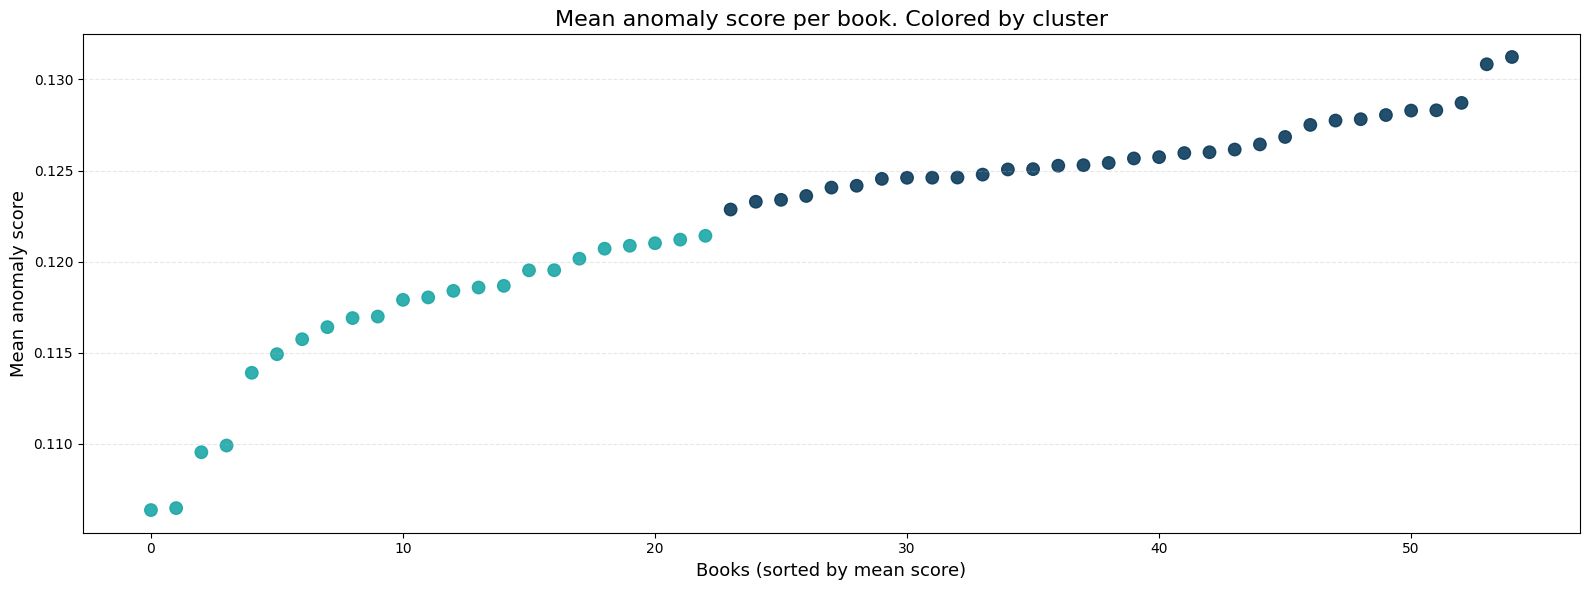

Saved: /content/drive/MyDrive/capstone/results/kmeans/aggregate/final/kmeans_clusters_scatter_plot_avg_sorted.png


In [ ]:
# Plot books sorted by mean anomaly score:
# x-axis = books sorted by mean score
# y-axis = mean anomaly score
# Saves to: results/kmeans/aggregate/final/kmeans_clusters_scatter_plot_avg_sorted.png

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/drive/MyDrive/capstone/results"
FINAL_DIR = os.path.join(RESULTS_DIR, "kmeans", "aggregate", "final")
os.makedirs(FINAL_DIR, exist_ok=True)

# Inputs produced by our Option A "final kmeans aggregate" cell
CLUSTERS_CSV = os.path.join(FINAL_DIR, "book_clusters_avg.csv")

# Input produced by our Option A IF aggregate cell
SCORE_AVG_CSV = os.path.join(RESULTS_DIR, "iforest", "aggregate", "score_matrix_avg.csv")

# Colors
CLUSTER_0_COLOR = "#0B3C5D"
CLUSTER_1_COLOR = "#1CA7A6"

# Load
clusters_df = pd.read_csv(CLUSTERS_CSV)            # columns: Book, Index, Cluster
avg_df = pd.read_csv(SCORE_AVG_CSV)                # columns: Book_Base, <pair1>, <pair2>, ...

if "Book_Base" not in avg_df.columns:
    raise ValueError(f"Expected Book_Base in {SCORE_AVG_CSV}")

pair_cols = [c for c in avg_df.columns if c != "Book_Base"]
avg_df[pair_cols] = avg_df[pair_cols].apply(pd.to_numeric, errors="coerce")

# Mean score per book
avg_df["MeanScore"] = avg_df[pair_cols].mean(axis=1, skipna=True)

# Merge with clusters
merged = avg_df.rename(columns={"Book_Base": "Book"})[["Book", "MeanScore"]].merge(
    clusters_df[["Book", "Cluster", "Index"]],
    on="Book",
    how="inner"
)

# Sort by mean score (this matches your figure)
merged = merged.sort_values("MeanScore", ascending=True).reset_index(drop=True)

# Colors per point
colors = merged["Cluster"].map({0: CLUSTER_0_COLOR, 1: CLUSTER_1_COLOR}).fillna(CLUSTER_0_COLOR).tolist()

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(
    range(len(merged)),
    merged["MeanScore"].values,
    c=colors,
    s=80,
    alpha=0.9
)

plt.title("Mean anomaly score per book. Colored by cluster", fontsize=16)
plt.xlabel("Books (sorted by mean score)", fontsize=13)
plt.ylabel("Mean anomaly score", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

out_png = os.path.join(FINAL_DIR, "kmeans_clusters_scatter_plot_avg_sorted.png")
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved:", out_png)

Clustering results saved to: /content/drive/MyDrive/capstone/results/kmeans/aggregate/final/book_clusters_avg.csv


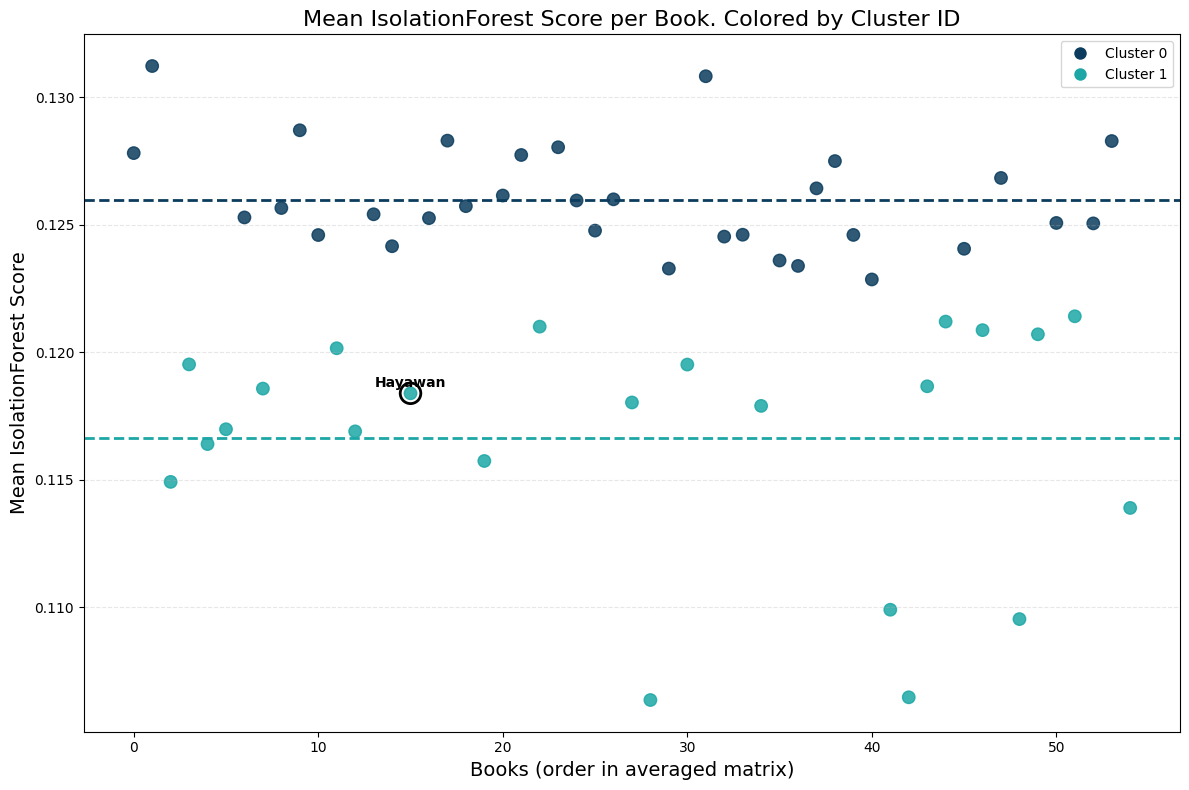

Cluster scatter plot saved to: /content/drive/MyDrive/capstone/results/kmeans/aggregate/final/kmeans_clusters_scatter_plot_avg.png
Saved meta: /content/drive/MyDrive/capstone/results/kmeans/aggregate/final/meta.json


In [ ]:
# FINAL KMEANS (AGGREGATE) MODULE .
# Reads from Drive:
# 1) results/dtw/aggregate/state.json  (books order)
# 2) results/iforest/aggregate/score_matrix_avg.csv  (your averaged matrix)
# 3) index mapping CSV (either no_duplicates or original)
# Writes to Drive:
# results/kmeans/aggregate/final/
#   - book_clusters_avg.csv
#   - kmeans_clusters_scatter_plot_avg.png
#   - meta.json

import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

# Paths
RESULTS_DIR = "/content/drive/MyDrive/capstone/results"

DTW_STATE_JSON = os.path.join(RESULTS_DIR, "dtw", "aggregate", "state.json")

IF_AGG_DIR = os.path.join(RESULTS_DIR, "iforest", "aggregate")
# From our Option A aggregate cell:
SCORE_AVG_CSV = os.path.join(IF_AGG_DIR, "score_matrix_avg.csv")  # has Book_Base + pair columns

KMEANS_AGG_DIR = os.path.join(RESULTS_DIR, "kmeans", "aggregate")
FINAL_DIR = os.path.join(KMEANS_AGG_DIR, "final")
os.makedirs(FINAL_DIR, exist_ok=True)

# Index mapping (use your preferred one)
INDEX_PATH = "/content/drive/MyDrive/capstone/test_data_table_no_duplicates.csv"  # or test_data_table.csv

# Settings
KMEANS_K = 2
KMEANS_RANDOM_STATE = 42

# Colors (keep your palette)
CLUSTER_0_COLOR = "#0B3C5D"  # deep blue
CLUSTER_1_COLOR = "#1CA7A6"  # teal

TARGET_BOOK_SUBSTRING = "Hayawan"  # highlight by substring (case-insensitive)

# Optional index annotations (keep as in your code)
highlight_indices = {2, 8, 11, 15, 23, 25, 26, 31, 24}
single_index = 22

# Small utils
def now_iso():
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def read_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def write_json(path: str, obj: dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# Load DTW state (books ordering for consistency across pipeline)
dtw_state = read_json(DTW_STATE_JSON)
books_order = dtw_state["books"]  # full list used in DTW/IF per-pair

# Load index mapping
index_df = pd.read_csv(INDEX_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Load averaged score matrix
# score_matrix_avg.csv from our IF aggregate cell is:
#   columns: Book_Base, <pair1>, <pair2>, ...
avg_df = pd.read_csv(SCORE_AVG_CSV)

if "Book_Base" not in avg_df.columns:
    raise ValueError(f"Expected column 'Book_Base' in {SCORE_AVG_CSV}")

# Make sure numeric columns are numeric
pair_cols = [c for c in avg_df.columns if c != "Book_Base"]
X = avg_df[pair_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)

# Books list for this clustering run
books = avg_df["Book_Base"].astype(str).tolist()

# Run KMeans on full score vectors (each book = vector across pairs)
kmeans = KMeans(n_clusters=KMEANS_K, random_state=KMEANS_RANDOM_STATE)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Save clustering results CSV
out_csv = os.path.join(FINAL_DIR, "book_clusters_avg.csv")

out_df = pd.DataFrame({
    "Book": books,
    "Index": [index_mapping.get(b, -1) for b in books],
    "Cluster": clusters,
})
out_df.to_csv(out_csv, index=False)
print("Clustering results saved to:", out_csv)

# Mean score per book (for 1D scatter)
mean_scores = np.nanmean(X, axis=1)

# Color assignment by cluster ID
point_colors = [CLUSTER_0_COLOR if c == 0 else CLUSTER_1_COLOR for c in clusters]

# Plot
plt.figure(figsize=(12, 8))

plt.scatter(
    range(len(books)),
    mean_scores,
    c=point_colors,
    s=80,
    alpha=0.85
)

# Highlight target book(s)
for i, book in enumerate(books):
    if TARGET_BOOK_SUBSTRING.lower() in book.lower():
        plt.scatter(
            i,
            mean_scores[i],
            s=220,
            facecolors="none",
            edgecolors="black",
            linewidths=2,
            zorder=5
        )
        plt.text(
            i,
            mean_scores[i] + (np.nanstd(mean_scores) * 0.02 if np.isfinite(np.nanstd(mean_scores)) else 0.001),
            TARGET_BOOK_SUBSTRING,
            fontsize=10,
            fontweight="bold",
            ha="center",
            va="bottom",
            color="black"
        )

# Optional index annotations
for i, y_val in enumerate(mean_scores):
    idx = out_df.iloc[i]["Index"]
    if idx == single_index:
        plt.text(i, y_val + 0.0005, str(idx), fontsize=8, ha="center")
    elif idx in highlight_indices:
        plt.text(i, y_val + 0.0005, str(idx), fontsize=8, ha="center", color="red")

# Centroid mean lines (mean across features for each cluster center)
centroid_means = np.nanmean(centroids, axis=1)
for c, m in enumerate(centroid_means):
    plt.axhline(
        m,
        linestyle="--",
        linewidth=2,
        color=CLUSTER_0_COLOR if c == 0 else CLUSTER_1_COLOR,
        label=f"Cluster {c} centroid"
    )

# Legend
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Cluster 0",
           markerfacecolor=CLUSTER_0_COLOR, markersize=10),
    Line2D([0], [0], marker="o", color="w", label="Cluster 1",
           markerfacecolor=CLUSTER_1_COLOR, markersize=10),
]
plt.legend(handles=legend_elements)

plt.title("Mean IsolationForest Score per Book. Colored by Cluster ID", fontsize=16)
plt.xlabel("Books (order in averaged matrix)", fontsize=14)
plt.ylabel("Mean IsolationForest Score", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

out_png = os.path.join(FINAL_DIR, "kmeans_clusters_scatter_plot_avg.png")
plt.savefig(out_png, dpi=300)
plt.show()

print("Cluster scatter plot saved to:", out_png)

# Save meta.json (so next steps can rely on it)
meta_path = os.path.join(FINAL_DIR, "meta.json")
write_json(meta_path, {
    "status": "ok",
    "created_at": now_iso(),
    "inputs": {
        "dtw_state_json": DTW_STATE_JSON,
        "iforest_score_matrix_avg_csv": SCORE_AVG_CSV,
        "index_csv": INDEX_PATH
    },
    "params": {
        "k": KMEANS_K,
        "random_state": KMEANS_RANDOM_STATE,
        "target_book_substring": TARGET_BOOK_SUBSTRING
    },
    "outputs": {
        "clusters_csv": out_csv,
        "scatter_png": out_png
    },
    "notes": {
        "X_shape": [int(X.shape[0]), int(X.shape[1])],
        "centroid_means": centroid_means.tolist()
    }
})
print("Saved meta:", meta_path)

Saved merged table: /content/drive/MyDrive/capstone/results/eval/confusion_matrix/merged_true_pred.csv
Saved metrics: /content/drive/MyDrive/capstone/results/eval/confusion_matrix/metrics.json


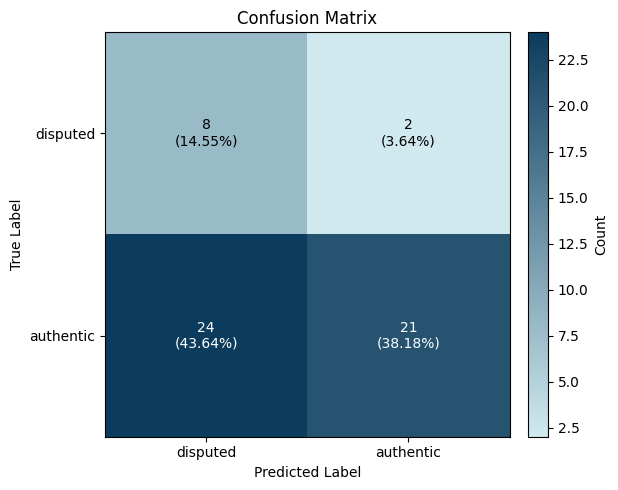

Saved plot: /content/drive/MyDrive/capstone/results/eval/confusion_matrix/confusion_matrix.png
Merged rows used: 55 . true: 55 . pred: 55


In [ ]:
# CONFUSION MATRIX MODULE
# Reads from Drive:
# 1) TRUE labels CSV: capstone/Jahiz_book_labels.csv
# 2) KMeans final CSV: results/kmeans/aggregate/final/book_clusters_avg.csv
# Writes to Drive:
# results/eval/confusion_matrix/
#   - merged_true_pred.csv
#   - confusion_matrix.png
#   - metrics.json

import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

# Paths
RESULTS_DIR = "/content/drive/MyDrive/capstone/results"

TRUE_CSV = "/content/drive/MyDrive/capstone/Jahiz_book_labels.csv"
PRED_CSV = os.path.join(RESULTS_DIR, "kmeans", "aggregate", "final", "book_clusters_avg.csv")

EVAL_DIR = os.path.join(RESULTS_DIR, "eval", "confusion_matrix")
os.makedirs(EVAL_DIR, exist_ok=True)

MERGED_OUT_CSV = os.path.join(EVAL_DIR, "merged_true_pred.csv")
CM_PNG = os.path.join(EVAL_DIR, "confusion_matrix.png")
METRICS_JSON = os.path.join(EVAL_DIR, "metrics.json")

# Settings
INVERT_PRED_CLUSTERS = False
CLASS_NAMES = ["disputed", "authentic"]  # label 0, label 1

# Custom sequential colormap
LIGHT_BLUE = "#CFE9EF"
DEEP_BLUE = "#0B3C5D"
blue_cmap = LinearSegmentedColormap.from_list("light_to_deep_blue", [LIGHT_BLUE, DEEP_BLUE])

# Utils
def now_iso():
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def write_json(path: str, obj: dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def normalize_book_id(x: str) -> str:
    """
    Normalizes IDs so:
    - trailing underscores are removed
    - trailing _<digits> are removed
    """
    s = str(x).strip()
    s = re.sub(r"_+$", "", s)
    s = re.sub(r"_(\d+)$", "", s)
    return s

# Load
true_df = pd.read_csv(TRUE_CSV)
pred_df = pd.read_csv(PRED_CSV)

# Basic validation
required_true_cols = {"book_name", "label"}
required_pred_cols = {"Book", "Cluster"}

missing_true = required_true_cols - set(true_df.columns)
missing_pred = required_pred_cols - set(pred_df.columns)

if missing_true:
    raise ValueError(f"TRUE_CSV missing columns: {missing_true}")
if missing_pred:
    raise ValueError(f"PRED_CSV missing columns: {missing_pred}")

# Normalize join keys
true_df["book_id"] = true_df["book_name"].map(normalize_book_id)
pred_df["book_id"] = pred_df["Book"].map(normalize_book_id)

# Merge
df = true_df.merge(pred_df, on="book_id", how="inner", suffixes=("_true", "_pred"))

# Save merged table for audit
df.to_csv(MERGED_OUT_CSV, index=False)
print("Saved merged table:", MERGED_OUT_CSV)

# Labels
y_true = df["label"].astype(int).to_numpy()
y_pred = df["Cluster"].astype(int).to_numpy()

if INVERT_PRED_CLUSTERS:
    y_pred = 1 - y_pred

# Confusion matrix + metrics
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
total = int(cm.sum())

tn, fp, fn, tp = int(cm[0, 0]), int(cm[0, 1]), int(cm[1, 0]), int(cm[1, 1])

accuracy = (tp + tn) / total if total else 0.0
precision_pos = tp / (tp + fp) if (tp + fp) else 0.0
recall_pos = tp / (tp + fn) if (tp + fn) else 0.0
f1_pos = (2 * precision_pos * recall_pos / (precision_pos + recall_pos)) if (precision_pos + recall_pos) else 0.0

metrics = {
    "status": "ok",
    "created_at": now_iso(),
    "inputs": {
        "true_csv": TRUE_CSV,
        "pred_csv": PRED_CSV,
        "invert_pred_clusters": INVERT_PRED_CLUSTERS,
        "class_names": CLASS_NAMES
    },
    "counts": {
        "n_true_rows": int(len(true_df)),
        "n_pred_rows": int(len(pred_df)),
        "n_merged_rows_used": int(len(df))
    },
    "confusion_matrix": {
        "labels": [0, 1],
        "matrix": cm.tolist(),
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "total": total
    },
    "metrics": {
        "accuracy": float(accuracy),
        "precision_authentic": float(precision_pos),
        "recall_authentic": float(recall_pos),
        "f1_authentic": float(f1_pos)
    },
    "outputs": {
        "merged_csv": MERGED_OUT_CSV,
        "confusion_png": CM_PNG,
        "metrics_json": METRICS_JSON
    }
}
write_json(METRICS_JSON, metrics)
print("Saved metrics:", METRICS_JSON)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=blue_cmap)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticklabels(CLASS_NAMES)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(2):
    for j in range(2):
        count = int(cm[i, j])
        pct = (count / total * 100) if total else 0
        ax.text(
            j, i,
            f"{count}\n({pct:.2f}%)",
            ha="center", va="center",
            color="white" if count > cm.max() * 0.6 else "black"
        )

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Count")
plt.tight_layout()
plt.savefig(CM_PNG, dpi=300)
plt.show()

print("Saved plot:", CM_PNG)
print("Merged rows used:", len(df), ". true:", len(true_df), ". pred:", len(pred_df))